# 120210203 권태현
---

## Import Lib

In [1]:
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential

from tensorflow import keras
from collections import deque          # To Saving Transitions
import matplotlib.pyplot as plt        # To Plotting graphs

from tqdm import tqdm

## Mountaincar-v0 Environment

In [2]:
import gym
env = gym.make('MountainCar-v0')

env.observation_space

Box([-1.2  -0.07], [0.6  0.07], (2,), float32)

In [27]:
print(env.observation_space.high)
print(env.observation_space.low)

[0.6  0.07]
[-1.2  -0.07]


## Model

In [8]:
class DQNagent:
    
    def __init__(self, init_state, init_action, episodes):
        self.init_state = init_state
        self.init_action = init_action
        self.episodes = episodes
                
        self.mini_batch = 64   # 16  32  64  128
        self.gamma = 0.95      # 0.85   0.9  0.95
        self.loss = tf.keras.losses.mean_squared_error
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
        
        
    def create_model(self):        
        state_input = self.init_state
                
        model = Sequential()        
        model.add(Dense(32, input_dim = state_input, activation = 'relu'))
        model.add(Dense(32, activation = 'relu'))
        
        model.add(Dense(self.init_action))
        return model
        
  
    def train_model(self, model):
        
        states, actions, rewards, next_states, dones = sample_experiences(self.mini_batch)
        mask = tf.one_hot(actions, self.init_action)
        
        next_Q_values = model.predict(next_states)
        max_next_Q_values = np.max(next_Q_values, axis=1)        
        target_Q_values = (rewards + (1 - dones) * self.gamma * max_next_Q_values)
        target_Q_values = target_Q_values.reshape(-1, 1)     
        
        with tf.GradientTape() as tape:
            all_Q_values = model(states)
            Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
            loss = tf.reduce_mean(self.loss(target_Q_values, Q_values))
            
        grads = tape.gradient(loss, model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, model.trainable_variables))
        

## Create Model

In [9]:
best_score = 200    # Fixed "200"
episodes = 1100     # 1000  1100  1500  2000
timestep = 200      # Fixed "200"

agent = DQNagent(env.observation_space.shape[0], env.action_space.n, episodes)
model = agent.create_model()
rewards = []

## Function related to Replay Buffer

In [10]:
Replay_Buffer = deque(maxlen=1000)              # Create Replay Buffer To Saving Transitions

def sample_experiences(mini_batch):
    idx = np.random.randint(len(Replay_Buffer), size=mini_batch)         # mini_batch = 64       
    batch = []
    for index in idx:
        batch.append(Replay_Buffer[index])

    # Transition
    states, actions, rewards, next_states, dones = [np.array([experience[field_index] for experience in batch]) for field_index in range(5)]        
    return states, actions, rewards, next_states, dones


def add_Buffer(state, action, reward, next_state, done):
    Replay_Buffer.append((state, action, reward, next_state, done))     # Add To Replay_Buffer
                    

## Starting Mountain Car

In [11]:
for episode in tqdm(range(episodes)):
    state = env.reset()    
    
    for step in range(timestep):
        # Step action by using Epsilon-Greedy Policy
        epsilon = max(1 - episode / (episodes * 0.8), 0.01)
        
        if np.random.rand() >= epsilon: 
            action = np.argmax(model.predict(state[np.newaxis])[0])            
        else:
            action = np.random.randint(env.action_space.n)
                    
        next_state, reward, done, info = env.step(action)
        
        if action == 2 and next_state[0] - state[0] > 0: 
            reward = 1            
        if action == 0 and next_state[0] - state[0] < 0: 
            reward = 1
            
        add_Buffer(state, action, reward, next_state, done)
        state = next_state.copy()
        
        if done:
            break
            
    rewards.append(step)
    
    # Training Model
    if step < best_score:
        best_weights = model.get_weights()
        best_score = step
        
    print("\rEpisode: {}, Best Score: {}, eps: {:.3f}".format(episode, best_score, epsilon), end="")
    
    if episode > 25:
        agent.train_model(model)

model.set_weights(best_weights)

env.close()

  0%|▎                                                                                | 5/1100 [00:00<00:28, 38.93it/s]

Episode: 6, Best Score: 199, eps: 0.993

  1%|▋                                                                                | 9/1100 [00:00<00:41, 26.46it/s]

Episode: 10, Best Score: 199, eps: 0.989

  1%|▊                                                                               | 12/1100 [00:00<00:54, 19.97it/s]

Episode: 13, Best Score: 199, eps: 0.985

  1%|█                                                                               | 15/1100 [00:00<01:07, 16.11it/s]

Episode: 14, Best Score: 199, eps: 0.984

  2%|█▏                                                                              | 17/1100 [00:01<01:41, 10.63it/s]

Episode: 16, Best Score: 199, eps: 0.982

  2%|█▍                                                                              | 19/1100 [00:01<01:40, 10.73it/s]

Episode: 18, Best Score: 199, eps: 0.980

  2%|█▌                                                                              | 21/1100 [00:01<02:13,  8.08it/s]

Episode: 20, Best Score: 199, eps: 0.977

  2%|█▋                                                                              | 23/1100 [00:01<02:09,  8.32it/s]

Episode: 22, Best Score: 199, eps: 0.975

  2%|█▊                                                                              | 25/1100 [00:02<02:25,  7.39it/s]

Episode: 24, Best Score: 199, eps: 0.973

  2%|█▉                                                                              | 27/1100 [00:02<02:42,  6.58it/s]

Episode: 26, Best Score: 199, eps: 0.970

  3%|██                                                                              | 28/1100 [00:02<02:42,  6.59it/s]

Episode: 28, Best Score: 199, eps: 0.968

  3%|██▏                                                                             | 30/1100 [00:03<03:13,  5.54it/s]

Episode: 30, Best Score: 199, eps: 0.966

  3%|██▎                                                                             | 32/1100 [00:03<03:10,  5.61it/s]

Episode: 31, Best Score: 199, eps: 0.965

  3%|██▍                                                                             | 33/1100 [00:03<03:53,  4.58it/s]

Episode: 32, Best Score: 199, eps: 0.964

  3%|██▍                                                                             | 34/1100 [00:04<03:54,  4.56it/s]

Episode: 33, Best Score: 199, eps: 0.963

  3%|██▌                                                                             | 35/1100 [00:04<04:17,  4.14it/s]

Episode: 34, Best Score: 199, eps: 0.961

  3%|██▌                                                                             | 36/1100 [00:04<04:19,  4.09it/s]

Episode: 35, Best Score: 199, eps: 0.960

  3%|██▋                                                                             | 37/1100 [00:04<04:27,  3.98it/s]

Episode: 36, Best Score: 199, eps: 0.959

  3%|██▊                                                                             | 38/1100 [00:05<04:17,  4.13it/s]

Episode: 38, Best Score: 199, eps: 0.957

  4%|██▉                                                                             | 40/1100 [00:05<04:02,  4.37it/s]

Episode: 39, Best Score: 199, eps: 0.956

  4%|██▉                                                                             | 41/1100 [00:05<04:15,  4.15it/s]

Episode: 40, Best Score: 199, eps: 0.955

  4%|███                                                                             | 42/1100 [00:06<04:16,  4.12it/s]

Episode: 41, Best Score: 199, eps: 0.953

  4%|███▏                                                                            | 43/1100 [00:06<04:24,  4.00it/s]

Episode: 43, Best Score: 199, eps: 0.951

  4%|███▎                                                                            | 45/1100 [00:07<05:17,  3.32it/s]

Episode: 44, Best Score: 199, eps: 0.950

  4%|███▍                                                                            | 47/1100 [00:07<04:48,  3.64it/s]

Episode: 47, Best Score: 199, eps: 0.947

  4%|███▌                                                                            | 49/1100 [00:07<04:11,  4.18it/s]

Episode: 48, Best Score: 199, eps: 0.945

  5%|███▋                                                                            | 50/1100 [00:08<04:47,  3.65it/s]

Episode: 49, Best Score: 199, eps: 0.944

  5%|███▋                                                                            | 51/1100 [00:08<04:38,  3.76it/s]

Episode: 50, Best Score: 199, eps: 0.943

  5%|███▊                                                                            | 52/1100 [00:08<04:52,  3.58it/s]

Episode: 51, Best Score: 199, eps: 0.942

  5%|███▊                                                                            | 53/1100 [00:09<05:11,  3.36it/s]

Episode: 52, Best Score: 199, eps: 0.941

  5%|███▉                                                                            | 54/1100 [00:09<04:57,  3.51it/s]

Episode: 53, Best Score: 199, eps: 0.940

  5%|████                                                                            | 55/1100 [00:09<05:01,  3.46it/s]

Episode: 54, Best Score: 199, eps: 0.939

  5%|████                                                                            | 56/1100 [00:10<05:01,  3.47it/s]

Episode: 55, Best Score: 199, eps: 0.938

  5%|████▏                                                                           | 57/1100 [00:10<05:23,  3.22it/s]

Episode: 56, Best Score: 199, eps: 0.936

  5%|████▏                                                                           | 58/1100 [00:10<05:25,  3.20it/s]

Episode: 57, Best Score: 199, eps: 0.935

  5%|████▎                                                                           | 59/1100 [00:11<05:43,  3.03it/s]

Episode: 58, Best Score: 199, eps: 0.934

  5%|████▎                                                                           | 60/1100 [00:11<06:01,  2.87it/s]

Episode: 59, Best Score: 199, eps: 0.933

  6%|████▍                                                                           | 61/1100 [00:11<06:08,  2.82it/s]

Episode: 60, Best Score: 199, eps: 0.932

  6%|████▌                                                                           | 62/1100 [00:12<05:53,  2.94it/s]

Episode: 61, Best Score: 199, eps: 0.931

  6%|████▌                                                                           | 63/1100 [00:12<05:57,  2.90it/s]

Episode: 62, Best Score: 199, eps: 0.930

  6%|████▋                                                                           | 64/1100 [00:12<05:48,  2.97it/s]

Episode: 63, Best Score: 199, eps: 0.928

  6%|████▋                                                                           | 65/1100 [00:13<05:32,  3.11it/s]

Episode: 64, Best Score: 199, eps: 0.927

  6%|████▊                                                                           | 66/1100 [00:13<06:27,  2.67it/s]

Episode: 65, Best Score: 199, eps: 0.926

  6%|████▊                                                                           | 67/1100 [00:14<06:21,  2.71it/s]

Episode: 66, Best Score: 199, eps: 0.925

  6%|████▉                                                                           | 68/1100 [00:14<06:28,  2.65it/s]

Episode: 67, Best Score: 199, eps: 0.924

  6%|█████                                                                           | 69/1100 [00:14<05:47,  2.97it/s]

Episode: 68, Best Score: 199, eps: 0.923

  6%|█████                                                                           | 70/1100 [00:15<06:29,  2.64it/s]

Episode: 69, Best Score: 199, eps: 0.922

  6%|█████▏                                                                          | 71/1100 [00:15<06:34,  2.61it/s]

Episode: 70, Best Score: 199, eps: 0.920

  7%|█████▏                                                                          | 72/1100 [00:15<06:32,  2.62it/s]

Episode: 71, Best Score: 199, eps: 0.919

  7%|█████▎                                                                          | 73/1100 [00:16<06:49,  2.51it/s]

Episode: 72, Best Score: 199, eps: 0.918

  7%|█████▍                                                                          | 74/1100 [00:16<07:18,  2.34it/s]

Episode: 73, Best Score: 199, eps: 0.917

  7%|█████▍                                                                          | 75/1100 [00:17<06:51,  2.49it/s]

Episode: 74, Best Score: 199, eps: 0.916

  7%|█████▌                                                                          | 76/1100 [00:17<06:45,  2.52it/s]

Episode: 75, Best Score: 199, eps: 0.915

  7%|█████▌                                                                          | 77/1100 [00:18<07:01,  2.43it/s]

Episode: 76, Best Score: 199, eps: 0.914

  7%|█████▋                                                                          | 78/1100 [00:18<07:20,  2.32it/s]

Episode: 77, Best Score: 199, eps: 0.912

  7%|█████▋                                                                          | 79/1100 [00:19<07:49,  2.17it/s]

Episode: 78, Best Score: 199, eps: 0.911

  7%|█████▊                                                                          | 80/1100 [00:19<07:01,  2.42it/s]

Episode: 79, Best Score: 199, eps: 0.910

  7%|█████▉                                                                          | 81/1100 [00:19<07:17,  2.33it/s]

Episode: 80, Best Score: 199, eps: 0.909

  7%|█████▉                                                                          | 82/1100 [00:20<07:26,  2.28it/s]

Episode: 81, Best Score: 199, eps: 0.908

  8%|██████                                                                          | 83/1100 [00:20<08:00,  2.12it/s]

Episode: 82, Best Score: 199, eps: 0.907

  8%|██████                                                                          | 84/1100 [00:21<07:26,  2.28it/s]

Episode: 83, Best Score: 199, eps: 0.906

  8%|██████▏                                                                         | 85/1100 [00:21<08:02,  2.10it/s]

Episode: 84, Best Score: 199, eps: 0.905

  8%|██████▎                                                                         | 86/1100 [00:22<09:26,  1.79it/s]

Episode: 85, Best Score: 199, eps: 0.903

  8%|██████▎                                                                         | 87/1100 [00:22<08:37,  1.96it/s]

Episode: 86, Best Score: 199, eps: 0.902

  8%|██████▍                                                                         | 88/1100 [00:23<10:34,  1.59it/s]

Episode: 87, Best Score: 199, eps: 0.901

  8%|██████▍                                                                         | 89/1100 [00:24<10:09,  1.66it/s]

Episode: 88, Best Score: 199, eps: 0.900

  8%|██████▌                                                                         | 90/1100 [00:25<10:56,  1.54it/s]

Episode: 89, Best Score: 199, eps: 0.899

  8%|██████▌                                                                         | 91/1100 [00:25<09:07,  1.84it/s]

Episode: 90, Best Score: 199, eps: 0.898

  8%|██████▋                                                                         | 92/1100 [00:25<08:09,  2.06it/s]

Episode: 91, Best Score: 199, eps: 0.897

  8%|██████▊                                                                         | 93/1100 [00:26<09:10,  1.83it/s]

Episode: 92, Best Score: 199, eps: 0.895

  9%|██████▊                                                                         | 94/1100 [00:26<09:01,  1.86it/s]

Episode: 93, Best Score: 199, eps: 0.894

  9%|██████▉                                                                         | 95/1100 [00:27<08:43,  1.92it/s]

Episode: 94, Best Score: 199, eps: 0.893

  9%|██████▉                                                                         | 96/1100 [00:27<08:48,  1.90it/s]

Episode: 95, Best Score: 199, eps: 0.892

  9%|███████                                                                         | 97/1100 [00:28<08:59,  1.86it/s]

Episode: 96, Best Score: 199, eps: 0.891

  9%|███████▏                                                                        | 98/1100 [00:29<09:38,  1.73it/s]

Episode: 97, Best Score: 199, eps: 0.890

  9%|███████▏                                                                        | 99/1100 [00:29<09:16,  1.80it/s]

Episode: 98, Best Score: 199, eps: 0.889

  9%|███████▏                                                                       | 100/1100 [00:30<09:21,  1.78it/s]

Episode: 99, Best Score: 199, eps: 0.887

  9%|███████▎                                                                       | 101/1100 [00:30<09:17,  1.79it/s]

Episode: 100, Best Score: 199, eps: 0.886

  9%|███████▎                                                                       | 102/1100 [00:31<10:18,  1.61it/s]

Episode: 101, Best Score: 199, eps: 0.885

  9%|███████▍                                                                       | 103/1100 [00:32<10:08,  1.64it/s]

Episode: 102, Best Score: 199, eps: 0.884

  9%|███████▍                                                                       | 104/1100 [00:32<10:21,  1.60it/s]

Episode: 103, Best Score: 199, eps: 0.883

 10%|███████▌                                                                       | 105/1100 [00:33<11:24,  1.45it/s]

Episode: 104, Best Score: 199, eps: 0.882

 10%|███████▌                                                                       | 106/1100 [00:34<10:30,  1.58it/s]

Episode: 105, Best Score: 199, eps: 0.881

 10%|███████▋                                                                       | 107/1100 [00:34<10:02,  1.65it/s]

Episode: 106, Best Score: 199, eps: 0.880

 10%|███████▊                                                                       | 108/1100 [00:35<10:51,  1.52it/s]

Episode: 107, Best Score: 199, eps: 0.878

 10%|███████▊                                                                       | 109/1100 [00:36<10:19,  1.60it/s]

Episode: 108, Best Score: 199, eps: 0.877

 10%|███████▉                                                                       | 110/1100 [00:36<09:48,  1.68it/s]

Episode: 109, Best Score: 199, eps: 0.876

 10%|███████▉                                                                       | 111/1100 [00:37<09:21,  1.76it/s]

Episode: 110, Best Score: 199, eps: 0.875

 10%|████████                                                                       | 112/1100 [00:37<09:11,  1.79it/s]

Episode: 111, Best Score: 199, eps: 0.874

 10%|████████                                                                       | 113/1100 [00:38<09:36,  1.71it/s]

Episode: 112, Best Score: 199, eps: 0.873

 10%|████████▏                                                                      | 114/1100 [00:38<09:45,  1.69it/s]

Episode: 113, Best Score: 199, eps: 0.872

 10%|████████▎                                                                      | 115/1100 [00:39<10:26,  1.57it/s]

Episode: 114, Best Score: 199, eps: 0.870

 11%|████████▎                                                                      | 116/1100 [00:40<09:45,  1.68it/s]

Episode: 115, Best Score: 199, eps: 0.869

 11%|████████▍                                                                      | 117/1100 [00:40<09:17,  1.76it/s]

Episode: 116, Best Score: 199, eps: 0.868

 11%|████████▍                                                                      | 118/1100 [00:41<10:04,  1.63it/s]

Episode: 117, Best Score: 199, eps: 0.867

 11%|████████▌                                                                      | 119/1100 [00:42<10:48,  1.51it/s]

Episode: 118, Best Score: 199, eps: 0.866

 11%|████████▌                                                                      | 120/1100 [00:43<12:14,  1.34it/s]

Episode: 119, Best Score: 199, eps: 0.865

 11%|████████▋                                                                      | 121/1100 [00:43<11:33,  1.41it/s]

Episode: 120, Best Score: 199, eps: 0.864

 11%|████████▊                                                                      | 122/1100 [00:44<11:12,  1.45it/s]

Episode: 121, Best Score: 199, eps: 0.863

 11%|████████▊                                                                      | 123/1100 [00:45<11:44,  1.39it/s]

Episode: 122, Best Score: 199, eps: 0.861

 11%|████████▉                                                                      | 124/1100 [00:45<11:41,  1.39it/s]

Episode: 123, Best Score: 199, eps: 0.860

 11%|████████▉                                                                      | 125/1100 [00:46<11:24,  1.42it/s]

Episode: 124, Best Score: 199, eps: 0.859

 11%|█████████                                                                      | 126/1100 [00:46<10:34,  1.53it/s]

Episode: 125, Best Score: 199, eps: 0.858

 12%|█████████                                                                      | 127/1100 [00:47<10:17,  1.57it/s]

Episode: 126, Best Score: 199, eps: 0.857

 12%|█████████▏                                                                     | 128/1100 [00:48<10:26,  1.55it/s]

Episode: 127, Best Score: 199, eps: 0.856

 12%|█████████▎                                                                     | 129/1100 [00:48<10:44,  1.51it/s]

Episode: 128, Best Score: 199, eps: 0.855

 12%|█████████▎                                                                     | 130/1100 [00:49<11:07,  1.45it/s]

Episode: 129, Best Score: 199, eps: 0.853

 12%|█████████▍                                                                     | 131/1100 [00:50<11:17,  1.43it/s]

Episode: 130, Best Score: 199, eps: 0.852

 12%|█████████▍                                                                     | 132/1100 [00:51<11:07,  1.45it/s]

Episode: 131, Best Score: 199, eps: 0.851

 12%|█████████▌                                                                     | 133/1100 [00:51<11:20,  1.42it/s]

Episode: 132, Best Score: 199, eps: 0.850

 12%|█████████▌                                                                     | 134/1100 [00:52<11:23,  1.41it/s]

Episode: 133, Best Score: 199, eps: 0.849

 12%|█████████▋                                                                     | 135/1100 [00:53<11:45,  1.37it/s]

Episode: 134, Best Score: 199, eps: 0.848

 12%|█████████▊                                                                     | 136/1100 [00:54<11:55,  1.35it/s]

Episode: 135, Best Score: 199, eps: 0.847

 12%|█████████▊                                                                     | 137/1100 [00:54<12:23,  1.29it/s]

Episode: 136, Best Score: 199, eps: 0.845

 13%|█████████▉                                                                     | 138/1100 [00:55<11:24,  1.40it/s]

Episode: 137, Best Score: 199, eps: 0.844

 13%|█████████▉                                                                     | 139/1100 [00:56<12:20,  1.30it/s]

Episode: 138, Best Score: 199, eps: 0.843

 13%|██████████                                                                     | 140/1100 [00:57<12:14,  1.31it/s]

Episode: 139, Best Score: 199, eps: 0.842

 13%|██████████▏                                                                    | 141/1100 [00:58<12:34,  1.27it/s]

Episode: 140, Best Score: 199, eps: 0.841

 13%|██████████▏                                                                    | 142/1100 [00:58<12:04,  1.32it/s]

Episode: 141, Best Score: 199, eps: 0.840

 13%|██████████▎                                                                    | 143/1100 [00:59<11:37,  1.37it/s]

Episode: 142, Best Score: 199, eps: 0.839

 13%|██████████▎                                                                    | 144/1100 [01:00<12:51,  1.24it/s]

Episode: 143, Best Score: 199, eps: 0.838

 13%|██████████▍                                                                    | 145/1100 [01:01<12:42,  1.25it/s]

Episode: 144, Best Score: 199, eps: 0.836

 13%|██████████▍                                                                    | 146/1100 [01:02<13:00,  1.22it/s]

Episode: 145, Best Score: 199, eps: 0.835

 13%|██████████▌                                                                    | 147/1100 [01:02<12:59,  1.22it/s]

Episode: 146, Best Score: 199, eps: 0.834

 13%|██████████▋                                                                    | 148/1100 [01:03<13:23,  1.18it/s]

Episode: 147, Best Score: 199, eps: 0.833

 14%|██████████▋                                                                    | 149/1100 [01:04<12:54,  1.23it/s]

Episode: 148, Best Score: 199, eps: 0.832

 14%|██████████▊                                                                    | 150/1100 [01:05<12:55,  1.22it/s]

Episode: 149, Best Score: 199, eps: 0.831

 14%|██████████▊                                                                    | 151/1100 [01:06<13:01,  1.21it/s]

Episode: 150, Best Score: 199, eps: 0.830

 14%|██████████▉                                                                    | 152/1100 [01:07<13:59,  1.13it/s]

Episode: 151, Best Score: 199, eps: 0.828

 14%|██████████▉                                                                    | 153/1100 [01:08<13:45,  1.15it/s]

Episode: 152, Best Score: 199, eps: 0.827

 14%|███████████                                                                    | 154/1100 [01:09<14:23,  1.09it/s]

Episode: 153, Best Score: 199, eps: 0.826

 14%|███████████▏                                                                   | 155/1100 [01:09<13:43,  1.15it/s]

Episode: 154, Best Score: 199, eps: 0.825

 14%|███████████▏                                                                   | 156/1100 [01:10<14:00,  1.12it/s]

Episode: 155, Best Score: 199, eps: 0.824

 14%|███████████▎                                                                   | 157/1100 [01:11<13:33,  1.16it/s]

Episode: 156, Best Score: 199, eps: 0.823

 14%|███████████▎                                                                   | 158/1100 [01:12<14:25,  1.09it/s]

Episode: 157, Best Score: 199, eps: 0.822

 14%|███████████▍                                                                   | 159/1100 [01:13<14:28,  1.08it/s]

Episode: 158, Best Score: 199, eps: 0.820

 15%|███████████▍                                                                   | 160/1100 [01:14<14:21,  1.09it/s]

Episode: 159, Best Score: 199, eps: 0.819

 15%|███████████▌                                                                   | 161/1100 [01:15<13:32,  1.16it/s]

Episode: 160, Best Score: 199, eps: 0.818

 15%|███████████▋                                                                   | 162/1100 [01:15<12:28,  1.25it/s]

Episode: 161, Best Score: 199, eps: 0.817

 15%|███████████▋                                                                   | 163/1100 [01:16<12:52,  1.21it/s]

Episode: 162, Best Score: 199, eps: 0.816

 15%|███████████▊                                                                   | 164/1100 [01:17<12:50,  1.21it/s]

Episode: 163, Best Score: 199, eps: 0.815

 15%|███████████▊                                                                   | 165/1100 [01:18<14:39,  1.06it/s]

Episode: 164, Best Score: 199, eps: 0.814

 15%|███████████▉                                                                   | 166/1100 [01:19<14:22,  1.08it/s]

Episode: 165, Best Score: 199, eps: 0.812

 15%|███████████▉                                                                   | 167/1100 [01:20<13:46,  1.13it/s]

Episode: 166, Best Score: 199, eps: 0.811

 15%|████████████                                                                   | 168/1100 [01:21<15:07,  1.03it/s]

Episode: 167, Best Score: 199, eps: 0.810

 15%|████████████▏                                                                  | 169/1100 [01:22<16:07,  1.04s/it]

Episode: 168, Best Score: 199, eps: 0.809

 15%|████████████▏                                                                  | 170/1100 [01:23<15:51,  1.02s/it]

Episode: 169, Best Score: 199, eps: 0.808

 16%|████████████▎                                                                  | 171/1100 [01:24<14:59,  1.03it/s]

Episode: 170, Best Score: 199, eps: 0.807

 16%|████████████▎                                                                  | 172/1100 [01:25<16:02,  1.04s/it]

Episode: 171, Best Score: 199, eps: 0.806

 16%|████████████▍                                                                  | 173/1100 [01:26<15:56,  1.03s/it]

Episode: 172, Best Score: 199, eps: 0.805

 16%|████████████▍                                                                  | 174/1100 [01:27<15:40,  1.02s/it]

Episode: 173, Best Score: 199, eps: 0.803

 16%|████████████▌                                                                  | 175/1100 [01:28<14:57,  1.03it/s]

Episode: 174, Best Score: 199, eps: 0.802

 16%|████████████▋                                                                  | 176/1100 [01:29<14:33,  1.06it/s]

Episode: 175, Best Score: 199, eps: 0.801

 16%|████████████▋                                                                  | 177/1100 [01:30<14:10,  1.09it/s]

Episode: 176, Best Score: 199, eps: 0.800

 16%|████████████▊                                                                  | 178/1100 [01:31<14:52,  1.03it/s]

Episode: 177, Best Score: 199, eps: 0.799

 16%|████████████▊                                                                  | 179/1100 [01:32<15:34,  1.02s/it]

Episode: 178, Best Score: 199, eps: 0.798

 16%|████████████▉                                                                  | 180/1100 [01:33<16:08,  1.05s/it]

Episode: 179, Best Score: 199, eps: 0.797

 16%|████████████▉                                                                  | 181/1100 [01:34<16:53,  1.10s/it]

Episode: 180, Best Score: 199, eps: 0.795

 17%|█████████████                                                                  | 182/1100 [01:36<16:51,  1.10s/it]

Episode: 181, Best Score: 199, eps: 0.794

 17%|█████████████▏                                                                 | 183/1100 [01:37<16:16,  1.06s/it]

Episode: 182, Best Score: 199, eps: 0.793

 17%|█████████████▏                                                                 | 184/1100 [01:37<14:33,  1.05it/s]

Episode: 183, Best Score: 199, eps: 0.792

 17%|█████████████▎                                                                 | 185/1100 [01:38<13:31,  1.13it/s]

Episode: 184, Best Score: 199, eps: 0.791

 17%|█████████████▎                                                                 | 186/1100 [01:39<13:55,  1.09it/s]

Episode: 185, Best Score: 199, eps: 0.790

 17%|█████████████▍                                                                 | 187/1100 [01:40<13:16,  1.15it/s]

Episode: 186, Best Score: 199, eps: 0.789

 17%|█████████████▌                                                                 | 188/1100 [01:41<13:12,  1.15it/s]

Episode: 187, Best Score: 199, eps: 0.787

 17%|█████████████▌                                                                 | 189/1100 [01:42<14:30,  1.05it/s]

Episode: 188, Best Score: 199, eps: 0.786

 17%|█████████████▋                                                                 | 190/1100 [01:43<15:17,  1.01s/it]

Episode: 189, Best Score: 199, eps: 0.785

 17%|█████████████▋                                                                 | 191/1100 [01:44<16:18,  1.08s/it]

Episode: 190, Best Score: 199, eps: 0.784

 17%|█████████████▊                                                                 | 192/1100 [01:45<15:41,  1.04s/it]

Episode: 191, Best Score: 199, eps: 0.783

 18%|█████████████▊                                                                 | 193/1100 [01:46<16:25,  1.09s/it]

Episode: 192, Best Score: 199, eps: 0.782

 18%|█████████████▉                                                                 | 194/1100 [01:47<17:04,  1.13s/it]

Episode: 193, Best Score: 199, eps: 0.781

 18%|██████████████                                                                 | 195/1100 [01:48<15:22,  1.02s/it]

Episode: 194, Best Score: 199, eps: 0.780

 18%|██████████████                                                                 | 196/1100 [01:50<16:34,  1.10s/it]

Episode: 195, Best Score: 199, eps: 0.778

 18%|██████████████▏                                                                | 197/1100 [01:51<17:17,  1.15s/it]

Episode: 196, Best Score: 199, eps: 0.777

 18%|██████████████▏                                                                | 198/1100 [01:52<16:08,  1.07s/it]

Episode: 197, Best Score: 199, eps: 0.776

 18%|██████████████▎                                                                | 199/1100 [01:53<15:48,  1.05s/it]

Episode: 198, Best Score: 199, eps: 0.775

 18%|██████████████▎                                                                | 200/1100 [01:54<15:36,  1.04s/it]

Episode: 199, Best Score: 199, eps: 0.774

 18%|██████████████▍                                                                | 201/1100 [01:55<16:19,  1.09s/it]

Episode: 200, Best Score: 199, eps: 0.773

 18%|██████████████▌                                                                | 202/1100 [01:56<16:58,  1.13s/it]

Episode: 201, Best Score: 199, eps: 0.772

 18%|██████████████▌                                                                | 203/1100 [01:57<16:01,  1.07s/it]

Episode: 202, Best Score: 199, eps: 0.770

 19%|██████████████▋                                                                | 204/1100 [01:58<15:25,  1.03s/it]

Episode: 203, Best Score: 199, eps: 0.769

 19%|██████████████▋                                                                | 205/1100 [01:59<16:09,  1.08s/it]

Episode: 204, Best Score: 199, eps: 0.768

 19%|██████████████▊                                                                | 206/1100 [02:00<16:09,  1.08s/it]

Episode: 205, Best Score: 199, eps: 0.767

 19%|██████████████▊                                                                | 207/1100 [02:02<16:50,  1.13s/it]

Episode: 206, Best Score: 199, eps: 0.766

 19%|██████████████▉                                                                | 208/1100 [02:03<16:43,  1.12s/it]

Episode: 207, Best Score: 199, eps: 0.765

 19%|███████████████                                                                | 209/1100 [02:04<16:07,  1.09s/it]

Episode: 208, Best Score: 199, eps: 0.764

 19%|███████████████                                                                | 210/1100 [02:05<16:13,  1.09s/it]

Episode: 209, Best Score: 199, eps: 0.762

 19%|███████████████▏                                                               | 211/1100 [02:06<16:04,  1.09s/it]

Episode: 210, Best Score: 199, eps: 0.761

 19%|███████████████▏                                                               | 212/1100 [02:07<16:25,  1.11s/it]

Episode: 211, Best Score: 199, eps: 0.760

 19%|███████████████▎                                                               | 213/1100 [02:08<17:47,  1.20s/it]

Episode: 212, Best Score: 199, eps: 0.759

 19%|███████████████▎                                                               | 214/1100 [02:10<17:37,  1.19s/it]

Episode: 213, Best Score: 199, eps: 0.758

 20%|███████████████▍                                                               | 215/1100 [02:11<17:04,  1.16s/it]

Episode: 214, Best Score: 199, eps: 0.757

 20%|███████████████▌                                                               | 216/1100 [02:12<17:53,  1.21s/it]

Episode: 215, Best Score: 199, eps: 0.756

 20%|███████████████▌                                                               | 217/1100 [02:13<18:08,  1.23s/it]

Episode: 216, Best Score: 199, eps: 0.755

 20%|███████████████▋                                                               | 218/1100 [02:15<18:08,  1.23s/it]

Episode: 217, Best Score: 199, eps: 0.753

 20%|███████████████▋                                                               | 219/1100 [02:15<16:54,  1.15s/it]

Episode: 218, Best Score: 199, eps: 0.752

 20%|███████████████▊                                                               | 220/1100 [02:17<16:24,  1.12s/it]

Episode: 219, Best Score: 199, eps: 0.751

 20%|███████████████▊                                                               | 221/1100 [02:18<17:41,  1.21s/it]

Episode: 220, Best Score: 199, eps: 0.750

 20%|███████████████▉                                                               | 222/1100 [02:19<17:43,  1.21s/it]

Episode: 221, Best Score: 199, eps: 0.749

 20%|████████████████                                                               | 223/1100 [02:20<18:03,  1.24s/it]

Episode: 222, Best Score: 199, eps: 0.748

 20%|████████████████                                                               | 224/1100 [02:22<18:04,  1.24s/it]

Episode: 223, Best Score: 199, eps: 0.747

 20%|████████████████▏                                                              | 225/1100 [02:23<19:27,  1.33s/it]

Episode: 224, Best Score: 199, eps: 0.745

 21%|████████████████▏                                                              | 226/1100 [02:25<19:57,  1.37s/it]

Episode: 225, Best Score: 199, eps: 0.744

 21%|████████████████▎                                                              | 227/1100 [02:26<20:38,  1.42s/it]

Episode: 226, Best Score: 199, eps: 0.743

 21%|████████████████▎                                                              | 228/1100 [02:27<19:48,  1.36s/it]

Episode: 227, Best Score: 199, eps: 0.742

 21%|████████████████▍                                                              | 229/1100 [02:29<19:07,  1.32s/it]

Episode: 228, Best Score: 199, eps: 0.741

 21%|████████████████▌                                                              | 230/1100 [02:30<18:57,  1.31s/it]

Episode: 229, Best Score: 199, eps: 0.740

 21%|████████████████▌                                                              | 231/1100 [02:31<18:35,  1.28s/it]

Episode: 230, Best Score: 199, eps: 0.739

 21%|████████████████▋                                                              | 232/1100 [02:32<18:13,  1.26s/it]

Episode: 231, Best Score: 199, eps: 0.738

 21%|████████████████▋                                                              | 233/1100 [02:34<18:08,  1.26s/it]

Episode: 232, Best Score: 199, eps: 0.736

 21%|████████████████▊                                                              | 234/1100 [02:35<19:00,  1.32s/it]

Episode: 233, Best Score: 199, eps: 0.735

 21%|████████████████▉                                                              | 235/1100 [02:37<19:51,  1.38s/it]

Episode: 234, Best Score: 199, eps: 0.734

 21%|████████████████▉                                                              | 236/1100 [02:38<19:41,  1.37s/it]

Episode: 235, Best Score: 199, eps: 0.733

 22%|█████████████████                                                              | 237/1100 [02:39<19:31,  1.36s/it]

Episode: 236, Best Score: 199, eps: 0.732

 22%|█████████████████                                                              | 238/1100 [02:41<19:34,  1.36s/it]

Episode: 237, Best Score: 199, eps: 0.731

 22%|█████████████████▏                                                             | 239/1100 [02:42<20:21,  1.42s/it]

Episode: 238, Best Score: 199, eps: 0.730

 22%|█████████████████▏                                                             | 240/1100 [02:43<19:40,  1.37s/it]

Episode: 239, Best Score: 199, eps: 0.728

 22%|█████████████████▎                                                             | 241/1100 [02:45<19:52,  1.39s/it]

Episode: 240, Best Score: 199, eps: 0.727

 22%|█████████████████▍                                                             | 242/1100 [02:46<20:38,  1.44s/it]

Episode: 241, Best Score: 199, eps: 0.726

 22%|█████████████████▍                                                             | 243/1100 [02:48<20:46,  1.45s/it]

Episode: 242, Best Score: 199, eps: 0.725

 22%|█████████████████▌                                                             | 244/1100 [02:50<21:26,  1.50s/it]

Episode: 243, Best Score: 199, eps: 0.724

 22%|█████████████████▌                                                             | 245/1100 [02:51<22:56,  1.61s/it]

Episode: 244, Best Score: 199, eps: 0.723

 22%|█████████████████▋                                                             | 246/1100 [02:53<22:33,  1.59s/it]

Episode: 245, Best Score: 199, eps: 0.722

 22%|█████████████████▋                                                             | 247/1100 [02:55<22:41,  1.60s/it]

Episode: 246, Best Score: 199, eps: 0.720

 23%|█████████████████▊                                                             | 248/1100 [02:57<24:05,  1.70s/it]

Episode: 247, Best Score: 199, eps: 0.719

 23%|█████████████████▉                                                             | 249/1100 [02:58<23:35,  1.66s/it]

Episode: 248, Best Score: 199, eps: 0.718

 23%|█████████████████▉                                                             | 250/1100 [03:00<23:13,  1.64s/it]

Episode: 249, Best Score: 199, eps: 0.717

 23%|██████████████████                                                             | 251/1100 [03:01<23:20,  1.65s/it]

Episode: 250, Best Score: 199, eps: 0.716

 23%|██████████████████                                                             | 252/1100 [03:03<23:26,  1.66s/it]

Episode: 251, Best Score: 199, eps: 0.715

 23%|██████████████████▏                                                            | 253/1100 [03:05<25:11,  1.78s/it]

Episode: 252, Best Score: 199, eps: 0.714

 23%|██████████████████▏                                                            | 254/1100 [03:07<24:38,  1.75s/it]

Episode: 253, Best Score: 199, eps: 0.713

 23%|██████████████████▎                                                            | 255/1100 [03:08<23:19,  1.66s/it]

Episode: 254, Best Score: 199, eps: 0.711

 23%|██████████████████▍                                                            | 256/1100 [03:10<23:31,  1.67s/it]

Episode: 255, Best Score: 199, eps: 0.710

 23%|██████████████████▍                                                            | 257/1100 [03:11<22:19,  1.59s/it]

Episode: 256, Best Score: 199, eps: 0.709

 23%|██████████████████▌                                                            | 258/1100 [03:13<21:34,  1.54s/it]

Episode: 257, Best Score: 199, eps: 0.708

 24%|██████████████████▌                                                            | 259/1100 [03:14<21:21,  1.52s/it]

Episode: 258, Best Score: 199, eps: 0.707

 24%|██████████████████▋                                                            | 260/1100 [03:16<21:41,  1.55s/it]

Episode: 259, Best Score: 199, eps: 0.706

 24%|██████████████████▋                                                            | 261/1100 [03:17<21:56,  1.57s/it]

Episode: 260, Best Score: 199, eps: 0.705

 24%|██████████████████▊                                                            | 262/1100 [03:19<22:24,  1.60s/it]

Episode: 261, Best Score: 199, eps: 0.703

 24%|██████████████████▉                                                            | 263/1100 [03:21<21:29,  1.54s/it]

Episode: 262, Best Score: 199, eps: 0.702

 24%|██████████████████▉                                                            | 264/1100 [03:22<21:00,  1.51s/it]

Episode: 263, Best Score: 199, eps: 0.701

 24%|███████████████████                                                            | 265/1100 [03:24<23:05,  1.66s/it]

Episode: 264, Best Score: 199, eps: 0.700

 24%|███████████████████                                                            | 266/1100 [03:26<22:58,  1.65s/it]

Episode: 265, Best Score: 199, eps: 0.699

 24%|███████████████████▏                                                           | 267/1100 [03:27<23:44,  1.71s/it]

Episode: 266, Best Score: 199, eps: 0.698

 24%|███████████████████▏                                                           | 268/1100 [03:29<23:33,  1.70s/it]

Episode: 267, Best Score: 199, eps: 0.697

 24%|███████████████████▎                                                           | 269/1100 [03:31<22:24,  1.62s/it]

Episode: 268, Best Score: 199, eps: 0.695

 25%|███████████████████▍                                                           | 270/1100 [03:32<22:23,  1.62s/it]

Episode: 269, Best Score: 199, eps: 0.694

 25%|███████████████████▍                                                           | 271/1100 [03:34<22:03,  1.60s/it]

Episode: 270, Best Score: 199, eps: 0.693

 25%|███████████████████▌                                                           | 272/1100 [03:36<22:48,  1.65s/it]

Episode: 271, Best Score: 199, eps: 0.692

 25%|███████████████████▌                                                           | 273/1100 [03:37<21:18,  1.55s/it]

Episode: 272, Best Score: 199, eps: 0.691

 25%|███████████████████▋                                                           | 274/1100 [03:39<22:32,  1.64s/it]

Episode: 273, Best Score: 199, eps: 0.690

 25%|███████████████████▊                                                           | 275/1100 [03:40<22:08,  1.61s/it]

Episode: 274, Best Score: 199, eps: 0.689

 25%|███████████████████▊                                                           | 276/1100 [03:42<23:14,  1.69s/it]

Episode: 275, Best Score: 199, eps: 0.688

 25%|███████████████████▉                                                           | 277/1100 [03:44<23:15,  1.70s/it]

Episode: 276, Best Score: 199, eps: 0.686

 25%|███████████████████▉                                                           | 278/1100 [03:45<23:11,  1.69s/it]

Episode: 277, Best Score: 199, eps: 0.685

 25%|████████████████████                                                           | 279/1100 [03:47<23:28,  1.72s/it]

Episode: 278, Best Score: 199, eps: 0.684

 25%|████████████████████                                                           | 280/1100 [03:49<23:28,  1.72s/it]

Episode: 279, Best Score: 199, eps: 0.683

 26%|████████████████████▏                                                          | 281/1100 [03:51<23:49,  1.75s/it]

Episode: 280, Best Score: 199, eps: 0.682

 26%|████████████████████▎                                                          | 282/1100 [03:52<23:34,  1.73s/it]

Episode: 281, Best Score: 199, eps: 0.681

 26%|████████████████████▎                                                          | 283/1100 [03:54<22:09,  1.63s/it]

Episode: 282, Best Score: 199, eps: 0.680

 26%|████████████████████▍                                                          | 284/1100 [03:56<22:30,  1.65s/it]

Episode: 283, Best Score: 199, eps: 0.678

 26%|████████████████████▍                                                          | 285/1100 [03:58<23:34,  1.74s/it]

Episode: 284, Best Score: 199, eps: 0.677

 26%|████████████████████▌                                                          | 286/1100 [03:59<22:59,  1.69s/it]

Episode: 285, Best Score: 199, eps: 0.676

 26%|████████████████████▌                                                          | 287/1100 [04:01<24:07,  1.78s/it]

Episode: 286, Best Score: 199, eps: 0.675

 26%|████████████████████▋                                                          | 288/1100 [04:03<24:18,  1.80s/it]

Episode: 287, Best Score: 199, eps: 0.674

 26%|████████████████████▊                                                          | 289/1100 [04:05<23:46,  1.76s/it]

Episode: 288, Best Score: 199, eps: 0.673

 26%|████████████████████▊                                                          | 290/1100 [04:06<23:57,  1.77s/it]

Episode: 289, Best Score: 199, eps: 0.672

 26%|████████████████████▉                                                          | 291/1100 [04:08<23:22,  1.73s/it]

Episode: 290, Best Score: 199, eps: 0.670

 27%|████████████████████▉                                                          | 292/1100 [04:10<23:49,  1.77s/it]

Episode: 291, Best Score: 199, eps: 0.669

 27%|█████████████████████                                                          | 293/1100 [04:12<24:32,  1.82s/it]

Episode: 292, Best Score: 199, eps: 0.668

 27%|█████████████████████                                                          | 294/1100 [04:14<24:33,  1.83s/it]

Episode: 293, Best Score: 199, eps: 0.667

 27%|█████████████████████▏                                                         | 295/1100 [04:16<24:40,  1.84s/it]

Episode: 294, Best Score: 199, eps: 0.666

 27%|█████████████████████▎                                                         | 296/1100 [04:17<23:31,  1.76s/it]

Episode: 295, Best Score: 199, eps: 0.665

 27%|█████████████████████▎                                                         | 297/1100 [04:19<24:05,  1.80s/it]

Episode: 296, Best Score: 199, eps: 0.664

 27%|█████████████████████▍                                                         | 298/1100 [04:21<23:31,  1.76s/it]

Episode: 297, Best Score: 199, eps: 0.662

 27%|█████████████████████▍                                                         | 299/1100 [04:23<24:11,  1.81s/it]

Episode: 298, Best Score: 199, eps: 0.661

 27%|█████████████████████▌                                                         | 300/1100 [04:24<22:35,  1.69s/it]

Episode: 299, Best Score: 199, eps: 0.660

 27%|█████████████████████▌                                                         | 301/1100 [04:26<22:27,  1.69s/it]

Episode: 300, Best Score: 199, eps: 0.659

 27%|█████████████████████▋                                                         | 302/1100 [04:28<24:02,  1.81s/it]

Episode: 301, Best Score: 199, eps: 0.658

 28%|█████████████████████▊                                                         | 303/1100 [04:30<23:42,  1.79s/it]

Episode: 302, Best Score: 199, eps: 0.657

 28%|█████████████████████▊                                                         | 304/1100 [04:32<25:12,  1.90s/it]

Episode: 303, Best Score: 199, eps: 0.656

 28%|█████████████████████▉                                                         | 305/1100 [04:34<24:58,  1.88s/it]

Episode: 304, Best Score: 199, eps: 0.655

 28%|█████████████████████▉                                                         | 306/1100 [04:35<24:24,  1.84s/it]

Episode: 305, Best Score: 199, eps: 0.653

 28%|██████████████████████                                                         | 307/1100 [04:37<22:51,  1.73s/it]

Episode: 306, Best Score: 199, eps: 0.652

 28%|██████████████████████                                                         | 308/1100 [04:39<22:53,  1.73s/it]

Episode: 307, Best Score: 199, eps: 0.651

 28%|██████████████████████▏                                                        | 309/1100 [04:40<22:58,  1.74s/it]

Episode: 308, Best Score: 199, eps: 0.650

 28%|██████████████████████▎                                                        | 310/1100 [04:42<23:28,  1.78s/it]

Episode: 309, Best Score: 199, eps: 0.649

 28%|██████████████████████▎                                                        | 311/1100 [04:44<24:37,  1.87s/it]

Episode: 310, Best Score: 199, eps: 0.648

 28%|██████████████████████▍                                                        | 312/1100 [04:46<23:48,  1.81s/it]

Episode: 311, Best Score: 199, eps: 0.647

 28%|██████████████████████▍                                                        | 313/1100 [04:48<23:03,  1.76s/it]

Episode: 312, Best Score: 199, eps: 0.645

 29%|██████████████████████▌                                                        | 314/1100 [04:50<23:58,  1.83s/it]

Episode: 313, Best Score: 199, eps: 0.644

 29%|██████████████████████▌                                                        | 315/1100 [04:52<25:09,  1.92s/it]

Episode: 314, Best Score: 199, eps: 0.643

 29%|██████████████████████▋                                                        | 316/1100 [04:53<23:22,  1.79s/it]

Episode: 315, Best Score: 199, eps: 0.642

 29%|██████████████████████▊                                                        | 317/1100 [04:55<23:22,  1.79s/it]

Episode: 316, Best Score: 199, eps: 0.641

 29%|██████████████████████▊                                                        | 318/1100 [04:57<23:34,  1.81s/it]

Episode: 317, Best Score: 199, eps: 0.640

 29%|██████████████████████▉                                                        | 319/1100 [04:59<25:09,  1.93s/it]

Episode: 318, Best Score: 199, eps: 0.639

 29%|██████████████████████▉                                                        | 320/1100 [05:01<25:53,  1.99s/it]

Episode: 319, Best Score: 199, eps: 0.637

 29%|███████████████████████                                                        | 321/1100 [05:03<25:07,  1.93s/it]

Episode: 320, Best Score: 199, eps: 0.636

 29%|███████████████████████▏                                                       | 322/1100 [05:05<24:22,  1.88s/it]

Episode: 321, Best Score: 199, eps: 0.635

 29%|███████████████████████▏                                                       | 323/1100 [05:07<24:48,  1.92s/it]

Episode: 322, Best Score: 199, eps: 0.634

 29%|███████████████████████▎                                                       | 324/1100 [05:09<25:05,  1.94s/it]

Episode: 323, Best Score: 199, eps: 0.633

 30%|███████████████████████▎                                                       | 325/1100 [05:11<24:34,  1.90s/it]

Episode: 324, Best Score: 199, eps: 0.632

 30%|███████████████████████▍                                                       | 326/1100 [05:13<25:03,  1.94s/it]

Episode: 325, Best Score: 199, eps: 0.631

 30%|███████████████████████▍                                                       | 327/1100 [05:15<25:08,  1.95s/it]

Episode: 326, Best Score: 199, eps: 0.630

 30%|███████████████████████▌                                                       | 328/1100 [05:16<24:27,  1.90s/it]

Episode: 327, Best Score: 199, eps: 0.628

 30%|███████████████████████▋                                                       | 329/1100 [05:19<25:36,  1.99s/it]

Episode: 328, Best Score: 199, eps: 0.627

 30%|███████████████████████▋                                                       | 330/1100 [05:20<25:12,  1.96s/it]

Episode: 329, Best Score: 199, eps: 0.626

 30%|███████████████████████▊                                                       | 331/1100 [05:22<24:49,  1.94s/it]

Episode: 330, Best Score: 199, eps: 0.625

 30%|███████████████████████▊                                                       | 332/1100 [05:25<25:55,  2.03s/it]

Episode: 331, Best Score: 199, eps: 0.624

 30%|███████████████████████▉                                                       | 333/1100 [05:26<25:43,  2.01s/it]

Episode: 332, Best Score: 199, eps: 0.623

 30%|███████████████████████▉                                                       | 334/1100 [05:28<24:49,  1.94s/it]

Episode: 333, Best Score: 199, eps: 0.622

 30%|████████████████████████                                                       | 335/1100 [05:30<24:36,  1.93s/it]

Episode: 334, Best Score: 199, eps: 0.620

 31%|████████████████████████▏                                                      | 336/1100 [05:33<27:02,  2.12s/it]

Episode: 335, Best Score: 199, eps: 0.619

 31%|████████████████████████▏                                                      | 337/1100 [05:35<26:47,  2.11s/it]

Episode: 336, Best Score: 199, eps: 0.618

 31%|████████████████████████▎                                                      | 338/1100 [05:37<26:54,  2.12s/it]

Episode: 337, Best Score: 199, eps: 0.617

 31%|████████████████████████▎                                                      | 339/1100 [05:39<28:10,  2.22s/it]

Episode: 338, Best Score: 199, eps: 0.616

 31%|████████████████████████▍                                                      | 340/1100 [05:41<26:37,  2.10s/it]

Episode: 339, Best Score: 199, eps: 0.615

 31%|████████████████████████▍                                                      | 341/1100 [05:44<27:16,  2.16s/it]

Episode: 340, Best Score: 199, eps: 0.614

 31%|████████████████████████▌                                                      | 342/1100 [05:46<27:18,  2.16s/it]

Episode: 341, Best Score: 199, eps: 0.613

 31%|████████████████████████▋                                                      | 343/1100 [05:48<26:42,  2.12s/it]

Episode: 342, Best Score: 199, eps: 0.611

 31%|████████████████████████▋                                                      | 344/1100 [05:50<27:55,  2.22s/it]

Episode: 343, Best Score: 199, eps: 0.610

 31%|████████████████████████▊                                                      | 345/1100 [05:52<26:16,  2.09s/it]

Episode: 344, Best Score: 199, eps: 0.609

 31%|████████████████████████▊                                                      | 346/1100 [05:54<25:58,  2.07s/it]

Episode: 345, Best Score: 199, eps: 0.608

 32%|████████████████████████▉                                                      | 347/1100 [05:56<24:54,  1.99s/it]

Episode: 346, Best Score: 199, eps: 0.607

 32%|████████████████████████▉                                                      | 348/1100 [05:58<26:05,  2.08s/it]

Episode: 347, Best Score: 199, eps: 0.606

 32%|█████████████████████████                                                      | 349/1100 [06:00<25:33,  2.04s/it]

Episode: 348, Best Score: 199, eps: 0.605

 32%|█████████████████████████▏                                                     | 350/1100 [06:02<24:50,  1.99s/it]

Episode: 349, Best Score: 199, eps: 0.603

 32%|█████████████████████████▏                                                     | 351/1100 [06:04<24:43,  1.98s/it]

Episode: 350, Best Score: 199, eps: 0.602

 32%|█████████████████████████▎                                                     | 352/1100 [06:06<26:12,  2.10s/it]

Episode: 351, Best Score: 199, eps: 0.601

 32%|█████████████████████████▎                                                     | 353/1100 [06:08<25:45,  2.07s/it]

Episode: 352, Best Score: 199, eps: 0.600

 32%|█████████████████████████▍                                                     | 354/1100 [06:10<25:15,  2.03s/it]

Episode: 353, Best Score: 199, eps: 0.599

 32%|█████████████████████████▍                                                     | 355/1100 [06:12<25:32,  2.06s/it]

Episode: 354, Best Score: 199, eps: 0.598

 32%|█████████████████████████▌                                                     | 356/1100 [06:14<25:29,  2.06s/it]

Episode: 355, Best Score: 199, eps: 0.597

 32%|█████████████████████████▋                                                     | 357/1100 [06:16<25:48,  2.08s/it]

Episode: 356, Best Score: 199, eps: 0.595

 33%|█████████████████████████▋                                                     | 358/1100 [06:18<24:27,  1.98s/it]

Episode: 357, Best Score: 199, eps: 0.594

 33%|█████████████████████████▊                                                     | 359/1100 [06:20<24:49,  2.01s/it]

Episode: 358, Best Score: 199, eps: 0.593

 33%|█████████████████████████▊                                                     | 360/1100 [06:22<24:39,  2.00s/it]

Episode: 359, Best Score: 199, eps: 0.592

 33%|█████████████████████████▉                                                     | 361/1100 [06:25<25:37,  2.08s/it]

Episode: 360, Best Score: 199, eps: 0.591

 33%|█████████████████████████▉                                                     | 362/1100 [06:27<25:19,  2.06s/it]

Episode: 361, Best Score: 199, eps: 0.590

 33%|██████████████████████████                                                     | 363/1100 [06:29<25:47,  2.10s/it]

Episode: 362, Best Score: 199, eps: 0.589

 33%|██████████████████████████▏                                                    | 364/1100 [06:31<25:43,  2.10s/it]

Episode: 363, Best Score: 199, eps: 0.588

 33%|██████████████████████████▏                                                    | 365/1100 [06:33<25:03,  2.05s/it]

Episode: 364, Best Score: 199, eps: 0.586

 33%|██████████████████████████▎                                                    | 366/1100 [06:35<25:11,  2.06s/it]

Episode: 365, Best Score: 199, eps: 0.585

 33%|██████████████████████████▎                                                    | 367/1100 [06:37<26:08,  2.14s/it]

Episode: 366, Best Score: 199, eps: 0.584

 33%|██████████████████████████▍                                                    | 368/1100 [06:39<25:41,  2.11s/it]

Episode: 367, Best Score: 199, eps: 0.583

 34%|██████████████████████████▌                                                    | 369/1100 [06:41<25:36,  2.10s/it]

Episode: 368, Best Score: 199, eps: 0.582

 34%|██████████████████████████▌                                                    | 370/1100 [06:44<26:38,  2.19s/it]

Episode: 369, Best Score: 199, eps: 0.581

 34%|██████████████████████████▋                                                    | 371/1100 [06:46<26:41,  2.20s/it]

Episode: 370, Best Score: 199, eps: 0.580

 34%|██████████████████████████▋                                                    | 372/1100 [06:48<25:44,  2.12s/it]

Episode: 371, Best Score: 199, eps: 0.578

 34%|██████████████████████████▊                                                    | 373/1100 [06:50<27:03,  2.23s/it]

Episode: 372, Best Score: 199, eps: 0.577

 34%|██████████████████████████▊                                                    | 374/1100 [06:53<27:04,  2.24s/it]

Episode: 373, Best Score: 199, eps: 0.576

 34%|██████████████████████████▉                                                    | 375/1100 [06:55<26:30,  2.19s/it]

Episode: 374, Best Score: 199, eps: 0.575

 34%|███████████████████████████                                                    | 376/1100 [06:57<25:52,  2.14s/it]

Episode: 375, Best Score: 199, eps: 0.574

 34%|███████████████████████████                                                    | 377/1100 [06:59<26:36,  2.21s/it]

Episode: 376, Best Score: 199, eps: 0.573

 34%|███████████████████████████▏                                                   | 378/1100 [07:01<26:44,  2.22s/it]

Episode: 377, Best Score: 199, eps: 0.572

 34%|███████████████████████████▏                                                   | 379/1100 [07:04<26:36,  2.21s/it]

Episode: 378, Best Score: 199, eps: 0.570

 35%|███████████████████████████▎                                                   | 380/1100 [07:06<26:30,  2.21s/it]

Episode: 379, Best Score: 199, eps: 0.569

 35%|███████████████████████████▎                                                   | 381/1100 [07:08<25:54,  2.16s/it]

Episode: 380, Best Score: 199, eps: 0.568

 35%|███████████████████████████▍                                                   | 382/1100 [07:10<26:26,  2.21s/it]

Episode: 381, Best Score: 199, eps: 0.567

 35%|███████████████████████████▌                                                   | 383/1100 [07:13<27:16,  2.28s/it]

Episode: 382, Best Score: 199, eps: 0.566

 35%|███████████████████████████▌                                                   | 384/1100 [07:15<27:38,  2.32s/it]

Episode: 383, Best Score: 199, eps: 0.565

 35%|███████████████████████████▋                                                   | 385/1100 [07:17<27:42,  2.32s/it]

Episode: 384, Best Score: 199, eps: 0.564

 35%|███████████████████████████▋                                                   | 386/1100 [07:20<27:31,  2.31s/it]

Episode: 385, Best Score: 199, eps: 0.562

 35%|███████████████████████████▊                                                   | 387/1100 [07:22<28:01,  2.36s/it]

Episode: 386, Best Score: 199, eps: 0.561

 35%|███████████████████████████▊                                                   | 388/1100 [07:25<28:41,  2.42s/it]

Episode: 387, Best Score: 199, eps: 0.560

 35%|███████████████████████████▉                                                   | 389/1100 [07:27<29:11,  2.46s/it]

Episode: 388, Best Score: 199, eps: 0.559

 35%|████████████████████████████                                                   | 390/1100 [07:29<28:26,  2.40s/it]

Episode: 389, Best Score: 199, eps: 0.558

 36%|████████████████████████████                                                   | 391/1100 [07:32<27:35,  2.34s/it]

Episode: 390, Best Score: 199, eps: 0.557

 36%|████████████████████████████▏                                                  | 392/1100 [07:34<27:22,  2.32s/it]

Episode: 391, Best Score: 199, eps: 0.556

 36%|████████████████████████████▏                                                  | 393/1100 [07:36<27:44,  2.35s/it]

Episode: 392, Best Score: 199, eps: 0.555

 36%|████████████████████████████▎                                                  | 394/1100 [07:39<27:30,  2.34s/it]

Episode: 393, Best Score: 199, eps: 0.553

 36%|████████████████████████████▎                                                  | 395/1100 [07:41<27:28,  2.34s/it]

Episode: 394, Best Score: 199, eps: 0.552

 36%|████████████████████████████▍                                                  | 396/1100 [07:43<27:44,  2.36s/it]

Episode: 395, Best Score: 199, eps: 0.551

 36%|████████████████████████████▌                                                  | 397/1100 [07:46<28:24,  2.43s/it]

Episode: 396, Best Score: 199, eps: 0.550

 36%|████████████████████████████▌                                                  | 398/1100 [07:48<28:42,  2.45s/it]

Episode: 397, Best Score: 199, eps: 0.549

 36%|████████████████████████████▋                                                  | 399/1100 [07:51<27:10,  2.33s/it]

Episode: 398, Best Score: 199, eps: 0.548

 36%|████████████████████████████▋                                                  | 400/1100 [07:53<27:16,  2.34s/it]

Episode: 399, Best Score: 199, eps: 0.547

 36%|████████████████████████████▊                                                  | 401/1100 [07:55<27:01,  2.32s/it]

Episode: 400, Best Score: 199, eps: 0.545

 37%|████████████████████████████▊                                                  | 402/1100 [07:58<27:27,  2.36s/it]

Episode: 401, Best Score: 199, eps: 0.544

 37%|████████████████████████████▉                                                  | 403/1100 [08:00<28:32,  2.46s/it]

Episode: 402, Best Score: 199, eps: 0.543

 37%|█████████████████████████████                                                  | 404/1100 [08:03<28:35,  2.46s/it]

Episode: 403, Best Score: 199, eps: 0.542

 37%|█████████████████████████████                                                  | 405/1100 [08:05<29:23,  2.54s/it]

Episode: 404, Best Score: 199, eps: 0.541

 37%|█████████████████████████████▏                                                 | 406/1100 [08:08<29:00,  2.51s/it]

Episode: 405, Best Score: 199, eps: 0.540

 37%|█████████████████████████████▏                                                 | 407/1100 [08:10<29:11,  2.53s/it]

Episode: 406, Best Score: 199, eps: 0.539

 37%|█████████████████████████████▎                                                 | 408/1100 [08:13<27:47,  2.41s/it]

Episode: 407, Best Score: 199, eps: 0.537

 37%|█████████████████████████████▎                                                 | 409/1100 [08:15<28:48,  2.50s/it]

Episode: 408, Best Score: 199, eps: 0.536

 37%|█████████████████████████████▍                                                 | 410/1100 [08:18<27:59,  2.43s/it]

Episode: 409, Best Score: 199, eps: 0.535

 37%|█████████████████████████████▌                                                 | 411/1100 [08:20<28:16,  2.46s/it]

Episode: 410, Best Score: 199, eps: 0.534

 37%|█████████████████████████████▌                                                 | 412/1100 [08:23<28:18,  2.47s/it]

Episode: 411, Best Score: 199, eps: 0.533

 38%|█████████████████████████████▋                                                 | 413/1100 [08:25<28:30,  2.49s/it]

Episode: 412, Best Score: 199, eps: 0.532

 38%|█████████████████████████████▋                                                 | 414/1100 [08:28<28:02,  2.45s/it]

Episode: 413, Best Score: 199, eps: 0.531

 38%|█████████████████████████████▊                                                 | 415/1100 [08:30<27:58,  2.45s/it]

Episode: 414, Best Score: 199, eps: 0.530

 38%|█████████████████████████████▉                                                 | 416/1100 [08:33<29:52,  2.62s/it]

Episode: 415, Best Score: 199, eps: 0.528

 38%|█████████████████████████████▉                                                 | 417/1100 [08:36<29:50,  2.62s/it]

Episode: 416, Best Score: 199, eps: 0.527

 38%|██████████████████████████████                                                 | 418/1100 [08:38<29:32,  2.60s/it]

Episode: 417, Best Score: 199, eps: 0.526

 38%|██████████████████████████████                                                 | 419/1100 [08:40<28:16,  2.49s/it]

Episode: 418, Best Score: 199, eps: 0.525

 38%|██████████████████████████████▏                                                | 420/1100 [08:43<27:35,  2.43s/it]

Episode: 419, Best Score: 199, eps: 0.524

 38%|██████████████████████████████▏                                                | 421/1100 [08:45<27:15,  2.41s/it]

Episode: 420, Best Score: 199, eps: 0.523

 38%|██████████████████████████████▎                                                | 422/1100 [08:48<27:31,  2.44s/it]

Episode: 421, Best Score: 199, eps: 0.522

 38%|██████████████████████████████▍                                                | 423/1100 [08:50<28:33,  2.53s/it]

Episode: 422, Best Score: 199, eps: 0.520

 39%|██████████████████████████████▍                                                | 424/1100 [08:53<28:45,  2.55s/it]

Episode: 423, Best Score: 199, eps: 0.519

 39%|██████████████████████████████▌                                                | 425/1100 [08:55<27:53,  2.48s/it]

Episode: 424, Best Score: 199, eps: 0.518

 39%|██████████████████████████████▌                                                | 426/1100 [08:58<27:44,  2.47s/it]

Episode: 425, Best Score: 199, eps: 0.517

 39%|██████████████████████████████▋                                                | 427/1100 [09:00<27:42,  2.47s/it]

Episode: 426, Best Score: 199, eps: 0.516

 39%|██████████████████████████████▋                                                | 428/1100 [09:03<27:47,  2.48s/it]

Episode: 427, Best Score: 199, eps: 0.515

 39%|██████████████████████████████▊                                                | 429/1100 [09:06<29:40,  2.65s/it]

Episode: 428, Best Score: 199, eps: 0.514

 39%|██████████████████████████████▉                                                | 430/1100 [09:08<29:17,  2.62s/it]

Episode: 429, Best Score: 199, eps: 0.512

 39%|██████████████████████████████▉                                                | 431/1100 [09:11<29:37,  2.66s/it]

Episode: 430, Best Score: 199, eps: 0.511

 39%|███████████████████████████████                                                | 432/1100 [09:14<29:56,  2.69s/it]

Episode: 431, Best Score: 199, eps: 0.510

 39%|███████████████████████████████                                                | 433/1100 [09:16<29:55,  2.69s/it]

Episode: 432, Best Score: 199, eps: 0.509

 39%|███████████████████████████████▏                                               | 434/1100 [09:19<30:21,  2.74s/it]

Episode: 433, Best Score: 199, eps: 0.508

 40%|███████████████████████████████▏                                               | 435/1100 [09:22<29:14,  2.64s/it]

Episode: 434, Best Score: 199, eps: 0.507

 40%|███████████████████████████████▎                                               | 436/1100 [09:25<29:56,  2.71s/it]

Episode: 435, Best Score: 199, eps: 0.506

 40%|███████████████████████████████▍                                               | 437/1100 [09:27<28:58,  2.62s/it]

Episode: 436, Best Score: 199, eps: 0.505

 40%|███████████████████████████████▍                                               | 438/1100 [09:29<28:08,  2.55s/it]

Episode: 437, Best Score: 199, eps: 0.503

 40%|███████████████████████████████▌                                               | 439/1100 [09:32<29:10,  2.65s/it]

Episode: 438, Best Score: 199, eps: 0.502

 40%|███████████████████████████████▌                                               | 440/1100 [09:35<29:22,  2.67s/it]

Episode: 439, Best Score: 199, eps: 0.501

 40%|███████████████████████████████▋                                               | 441/1100 [09:38<29:05,  2.65s/it]

Episode: 440, Best Score: 199, eps: 0.500

 40%|███████████████████████████████▋                                               | 442/1100 [09:40<28:52,  2.63s/it]

Episode: 441, Best Score: 199, eps: 0.499

 40%|███████████████████████████████▊                                               | 443/1100 [09:43<28:38,  2.62s/it]

Episode: 442, Best Score: 199, eps: 0.498

 40%|███████████████████████████████▉                                               | 444/1100 [09:46<29:51,  2.73s/it]

Episode: 443, Best Score: 199, eps: 0.497

 40%|███████████████████████████████▉                                               | 445/1100 [09:48<29:15,  2.68s/it]

Episode: 444, Best Score: 199, eps: 0.495

 41%|████████████████████████████████                                               | 446/1100 [09:51<29:10,  2.68s/it]

Episode: 445, Best Score: 199, eps: 0.494

 41%|████████████████████████████████                                               | 447/1100 [09:54<29:32,  2.71s/it]

Episode: 446, Best Score: 199, eps: 0.493

 41%|████████████████████████████████▏                                              | 448/1100 [09:56<29:28,  2.71s/it]

Episode: 447, Best Score: 199, eps: 0.492

 41%|████████████████████████████████▏                                              | 449/1100 [09:59<29:42,  2.74s/it]

Episode: 448, Best Score: 199, eps: 0.491

 41%|████████████████████████████████▎                                              | 450/1100 [10:02<29:33,  2.73s/it]

Episode: 449, Best Score: 199, eps: 0.490

 41%|████████████████████████████████▍                                              | 451/1100 [10:04<28:03,  2.59s/it]

Episode: 450, Best Score: 199, eps: 0.489

 41%|████████████████████████████████▍                                              | 452/1100 [10:07<28:15,  2.62s/it]

Episode: 451, Best Score: 199, eps: 0.488

 41%|████████████████████████████████▌                                              | 453/1100 [10:10<29:11,  2.71s/it]

Episode: 452, Best Score: 199, eps: 0.486

 41%|████████████████████████████████▌                                              | 454/1100 [10:12<28:49,  2.68s/it]

Episode: 453, Best Score: 199, eps: 0.485

 41%|████████████████████████████████▋                                              | 455/1100 [10:15<28:33,  2.66s/it]

Episode: 454, Best Score: 199, eps: 0.484

 41%|████████████████████████████████▋                                              | 456/1100 [10:18<28:34,  2.66s/it]

Episode: 455, Best Score: 199, eps: 0.483

 42%|████████████████████████████████▊                                              | 457/1100 [10:20<28:20,  2.64s/it]

Episode: 456, Best Score: 199, eps: 0.482

 42%|████████████████████████████████▉                                              | 458/1100 [10:23<27:57,  2.61s/it]

Episode: 457, Best Score: 199, eps: 0.481

 42%|████████████████████████████████▉                                              | 459/1100 [10:26<28:16,  2.65s/it]

Episode: 458, Best Score: 199, eps: 0.480

 42%|█████████████████████████████████                                              | 460/1100 [10:29<29:10,  2.74s/it]

Episode: 459, Best Score: 199, eps: 0.478

 42%|█████████████████████████████████                                              | 461/1100 [10:31<29:24,  2.76s/it]

Episode: 460, Best Score: 199, eps: 0.477

 42%|█████████████████████████████████▏                                             | 462/1100 [10:34<29:35,  2.78s/it]

Episode: 461, Best Score: 199, eps: 0.476

 42%|█████████████████████████████████▎                                             | 463/1100 [10:37<29:30,  2.78s/it]

Episode: 462, Best Score: 199, eps: 0.475

 42%|█████████████████████████████████▎                                             | 464/1100 [10:39<28:23,  2.68s/it]

Episode: 463, Best Score: 199, eps: 0.474

 42%|█████████████████████████████████▍                                             | 465/1100 [10:42<29:04,  2.75s/it]

Episode: 464, Best Score: 199, eps: 0.473

 42%|█████████████████████████████████▍                                             | 466/1100 [10:45<28:17,  2.68s/it]

Episode: 465, Best Score: 199, eps: 0.472

 42%|█████████████████████████████████▌                                             | 467/1100 [10:48<28:32,  2.70s/it]

Episode: 466, Best Score: 199, eps: 0.470

 43%|█████████████████████████████████▌                                             | 468/1100 [10:50<28:43,  2.73s/it]

Episode: 467, Best Score: 199, eps: 0.469

 43%|█████████████████████████████████▋                                             | 469/1100 [10:53<28:04,  2.67s/it]

Episode: 468, Best Score: 199, eps: 0.468

 43%|█████████████████████████████████▊                                             | 470/1100 [10:56<27:42,  2.64s/it]

Episode: 469, Best Score: 199, eps: 0.467

 43%|█████████████████████████████████▊                                             | 471/1100 [10:59<28:56,  2.76s/it]

Episode: 470, Best Score: 199, eps: 0.466

 43%|█████████████████████████████████▉                                             | 472/1100 [11:01<28:54,  2.76s/it]

Episode: 471, Best Score: 199, eps: 0.465

 43%|█████████████████████████████████▉                                             | 473/1100 [11:04<28:27,  2.72s/it]

Episode: 472, Best Score: 199, eps: 0.464

 43%|██████████████████████████████████                                             | 474/1100 [11:07<28:26,  2.73s/it]

Episode: 473, Best Score: 199, eps: 0.463

 43%|██████████████████████████████████                                             | 475/1100 [11:10<29:23,  2.82s/it]

Episode: 474, Best Score: 199, eps: 0.461

 43%|██████████████████████████████████▏                                            | 476/1100 [11:13<29:49,  2.87s/it]

Episode: 475, Best Score: 199, eps: 0.460

 43%|██████████████████████████████████▎                                            | 477/1100 [11:15<28:54,  2.78s/it]

Episode: 476, Best Score: 199, eps: 0.459

 43%|██████████████████████████████████▎                                            | 478/1100 [11:18<28:46,  2.78s/it]

Episode: 477, Best Score: 199, eps: 0.458

 44%|██████████████████████████████████▍                                            | 479/1100 [11:21<29:00,  2.80s/it]

Episode: 478, Best Score: 199, eps: 0.457

 44%|██████████████████████████████████▍                                            | 480/1100 [11:24<29:17,  2.83s/it]

Episode: 479, Best Score: 199, eps: 0.456

 44%|██████████████████████████████████▌                                            | 481/1100 [11:27<29:12,  2.83s/it]

Episode: 480, Best Score: 199, eps: 0.455

 44%|██████████████████████████████████▌                                            | 482/1100 [11:30<30:10,  2.93s/it]

Episode: 481, Best Score: 199, eps: 0.453

 44%|██████████████████████████████████▋                                            | 483/1100 [11:33<30:18,  2.95s/it]

Episode: 482, Best Score: 199, eps: 0.452

 44%|██████████████████████████████████▊                                            | 484/1100 [11:36<30:49,  3.00s/it]

Episode: 483, Best Score: 199, eps: 0.451

 44%|██████████████████████████████████▊                                            | 485/1100 [11:39<30:35,  2.98s/it]

Episode: 484, Best Score: 199, eps: 0.450

 44%|██████████████████████████████████▉                                            | 486/1100 [11:42<30:36,  2.99s/it]

Episode: 485, Best Score: 199, eps: 0.449

 44%|██████████████████████████████████▉                                            | 487/1100 [11:44<29:06,  2.85s/it]

Episode: 486, Best Score: 199, eps: 0.448

 44%|███████████████████████████████████                                            | 488/1100 [11:47<28:32,  2.80s/it]

Episode: 487, Best Score: 199, eps: 0.447

 44%|███████████████████████████████████                                            | 489/1100 [11:50<28:39,  2.82s/it]

Episode: 488, Best Score: 199, eps: 0.445

 45%|███████████████████████████████████▏                                           | 490/1100 [11:53<29:11,  2.87s/it]

Episode: 489, Best Score: 199, eps: 0.444

 45%|███████████████████████████████████▎                                           | 491/1100 [11:56<28:57,  2.85s/it]

Episode: 490, Best Score: 199, eps: 0.443

 45%|███████████████████████████████████▎                                           | 492/1100 [11:59<29:31,  2.91s/it]

Episode: 491, Best Score: 199, eps: 0.442

 45%|███████████████████████████████████▍                                           | 493/1100 [12:02<29:30,  2.92s/it]

Episode: 492, Best Score: 199, eps: 0.441

 45%|███████████████████████████████████▍                                           | 494/1100 [12:05<29:05,  2.88s/it]

Episode: 493, Best Score: 199, eps: 0.440

 45%|███████████████████████████████████▌                                           | 495/1100 [12:08<29:47,  2.96s/it]

Episode: 494, Best Score: 199, eps: 0.439

 45%|███████████████████████████████████▌                                           | 496/1100 [12:11<30:25,  3.02s/it]

Episode: 495, Best Score: 199, eps: 0.438

 45%|███████████████████████████████████▋                                           | 497/1100 [12:14<29:56,  2.98s/it]

Episode: 496, Best Score: 199, eps: 0.436

 45%|███████████████████████████████████▊                                           | 498/1100 [12:17<30:06,  3.00s/it]

Episode: 497, Best Score: 199, eps: 0.435

 45%|███████████████████████████████████▊                                           | 499/1100 [12:20<29:56,  2.99s/it]

Episode: 498, Best Score: 199, eps: 0.434

 45%|███████████████████████████████████▉                                           | 500/1100 [12:23<29:54,  2.99s/it]

Episode: 499, Best Score: 199, eps: 0.433

 46%|███████████████████████████████████▉                                           | 501/1100 [12:26<29:47,  2.98s/it]

Episode: 500, Best Score: 199, eps: 0.432

 46%|████████████████████████████████████                                           | 502/1100 [12:28<29:11,  2.93s/it]

Episode: 501, Best Score: 199, eps: 0.431

 46%|████████████████████████████████████                                           | 503/1100 [12:32<29:34,  2.97s/it]

Episode: 502, Best Score: 199, eps: 0.430

 46%|████████████████████████████████████▏                                          | 504/1100 [12:34<28:46,  2.90s/it]

Episode: 503, Best Score: 199, eps: 0.428

 46%|████████████████████████████████████▎                                          | 505/1100 [12:37<29:10,  2.94s/it]

Episode: 504, Best Score: 199, eps: 0.427

 46%|████████████████████████████████████▎                                          | 506/1100 [12:40<29:22,  2.97s/it]

Episode: 505, Best Score: 199, eps: 0.426

 46%|████████████████████████████████████▍                                          | 507/1100 [12:44<30:19,  3.07s/it]

Episode: 506, Best Score: 199, eps: 0.425

 46%|████████████████████████████████████▍                                          | 508/1100 [12:47<31:10,  3.16s/it]

Episode: 507, Best Score: 199, eps: 0.424

 46%|████████████████████████████████████▌                                          | 509/1100 [12:50<31:25,  3.19s/it]

Episode: 508, Best Score: 199, eps: 0.423

 46%|████████████████████████████████████▋                                          | 510/1100 [12:53<30:46,  3.13s/it]

Episode: 509, Best Score: 199, eps: 0.422

 46%|████████████████████████████████████▋                                          | 511/1100 [12:56<30:53,  3.15s/it]

Episode: 510, Best Score: 199, eps: 0.420

 47%|████████████████████████████████████▊                                          | 512/1100 [12:59<30:12,  3.08s/it]

Episode: 511, Best Score: 199, eps: 0.419

 47%|████████████████████████████████████▊                                          | 513/1100 [13:02<29:53,  3.06s/it]

Episode: 512, Best Score: 199, eps: 0.418

 47%|████████████████████████████████████▉                                          | 514/1100 [13:05<30:00,  3.07s/it]

Episode: 513, Best Score: 199, eps: 0.417

 47%|████████████████████████████████████▉                                          | 515/1100 [13:09<30:38,  3.14s/it]

Episode: 514, Best Score: 199, eps: 0.416

 47%|█████████████████████████████████████                                          | 516/1100 [13:11<28:47,  2.96s/it]

Episode: 515, Best Score: 199, eps: 0.415

 47%|█████████████████████████████████████▏                                         | 517/1100 [13:14<28:54,  2.97s/it]

Episode: 516, Best Score: 199, eps: 0.414

 47%|█████████████████████████████████████▏                                         | 518/1100 [13:17<29:21,  3.03s/it]

Episode: 517, Best Score: 199, eps: 0.412

 47%|█████████████████████████████████████▎                                         | 519/1100 [13:20<28:48,  2.98s/it]

Episode: 518, Best Score: 199, eps: 0.411

 47%|█████████████████████████████████████▎                                         | 520/1100 [13:23<28:30,  2.95s/it]

Episode: 519, Best Score: 199, eps: 0.410

 47%|█████████████████████████████████████▍                                         | 521/1100 [13:26<28:21,  2.94s/it]

Episode: 520, Best Score: 199, eps: 0.409

 47%|█████████████████████████████████████▍                                         | 522/1100 [13:29<28:45,  2.99s/it]

Episode: 521, Best Score: 199, eps: 0.408

 48%|█████████████████████████████████████▌                                         | 523/1100 [13:33<29:40,  3.08s/it]

Episode: 522, Best Score: 199, eps: 0.407

 48%|█████████████████████████████████████▋                                         | 524/1100 [13:36<30:23,  3.17s/it]

Episode: 523, Best Score: 199, eps: 0.406

 48%|█████████████████████████████████████▋                                         | 525/1100 [13:39<30:27,  3.18s/it]

Episode: 524, Best Score: 199, eps: 0.405

 48%|█████████████████████████████████████▊                                         | 526/1100 [13:42<30:13,  3.16s/it]

Episode: 525, Best Score: 199, eps: 0.403

 48%|█████████████████████████████████████▊                                         | 527/1100 [13:45<29:46,  3.12s/it]

Episode: 526, Best Score: 199, eps: 0.402

 48%|█████████████████████████████████████▉                                         | 528/1100 [13:48<29:46,  3.12s/it]

Episode: 527, Best Score: 199, eps: 0.401

 48%|█████████████████████████████████████▉                                         | 529/1100 [13:51<28:56,  3.04s/it]

Episode: 528, Best Score: 199, eps: 0.400

 48%|██████████████████████████████████████                                         | 530/1100 [13:54<29:11,  3.07s/it]

Episode: 529, Best Score: 199, eps: 0.399

 48%|██████████████████████████████████████▏                                        | 531/1100 [13:58<29:17,  3.09s/it]

Episode: 530, Best Score: 199, eps: 0.398

 48%|██████████████████████████████████████▏                                        | 532/1100 [14:00<28:57,  3.06s/it]

Episode: 531, Best Score: 199, eps: 0.397

 48%|██████████████████████████████████████▎                                        | 533/1100 [14:03<28:35,  3.03s/it]

Episode: 532, Best Score: 199, eps: 0.395

 49%|██████████████████████████████████████▎                                        | 534/1100 [14:06<28:31,  3.02s/it]

Episode: 533, Best Score: 199, eps: 0.394

 49%|██████████████████████████████████████▍                                        | 535/1100 [14:10<28:42,  3.05s/it]

Episode: 534, Best Score: 199, eps: 0.393

 49%|██████████████████████████████████████▍                                        | 536/1100 [14:13<29:18,  3.12s/it]

Episode: 535, Best Score: 199, eps: 0.392

 49%|██████████████████████████████████████▌                                        | 537/1100 [14:16<28:39,  3.05s/it]

Episode: 536, Best Score: 199, eps: 0.391

 49%|██████████████████████████████████████▋                                        | 538/1100 [14:19<28:29,  3.04s/it]

Episode: 537, Best Score: 199, eps: 0.390

 49%|██████████████████████████████████████▋                                        | 539/1100 [14:22<28:41,  3.07s/it]

Episode: 538, Best Score: 199, eps: 0.389

 49%|██████████████████████████████████████▊                                        | 540/1100 [14:25<29:01,  3.11s/it]

Episode: 539, Best Score: 199, eps: 0.387

 49%|██████████████████████████████████████▊                                        | 541/1100 [14:28<28:16,  3.03s/it]

Episode: 540, Best Score: 199, eps: 0.386

 49%|██████████████████████████████████████▉                                        | 542/1100 [14:31<28:30,  3.07s/it]

Episode: 541, Best Score: 199, eps: 0.385

 49%|██████████████████████████████████████▉                                        | 543/1100 [14:34<29:19,  3.16s/it]

Episode: 542, Best Score: 199, eps: 0.384

 49%|███████████████████████████████████████                                        | 544/1100 [14:37<28:46,  3.10s/it]

Episode: 543, Best Score: 199, eps: 0.383

 50%|███████████████████████████████████████▏                                       | 545/1100 [14:40<27:57,  3.02s/it]

Episode: 544, Best Score: 199, eps: 0.382

 50%|███████████████████████████████████████▏                                       | 546/1100 [14:44<28:56,  3.13s/it]

Episode: 545, Best Score: 199, eps: 0.381

 50%|███████████████████████████████████████▎                                       | 547/1100 [14:47<29:40,  3.22s/it]

Episode: 546, Best Score: 199, eps: 0.380

 50%|███████████████████████████████████████▎                                       | 548/1100 [14:50<29:12,  3.18s/it]

Episode: 547, Best Score: 199, eps: 0.378

 50%|███████████████████████████████████████▍                                       | 549/1100 [14:53<28:52,  3.14s/it]

Episode: 548, Best Score: 199, eps: 0.377

 50%|███████████████████████████████████████▌                                       | 550/1100 [14:57<29:27,  3.21s/it]

Episode: 549, Best Score: 199, eps: 0.376

 50%|███████████████████████████████████████▌                                       | 551/1100 [14:59<28:25,  3.11s/it]

Episode: 550, Best Score: 182, eps: 0.375

 50%|███████████████████████████████████████▋                                       | 552/1100 [15:03<28:21,  3.10s/it]

Episode: 551, Best Score: 181, eps: 0.374

 50%|███████████████████████████████████████▋                                       | 553/1100 [15:06<28:25,  3.12s/it]

Episode: 552, Best Score: 181, eps: 0.373

 50%|███████████████████████████████████████▊                                       | 554/1100 [15:09<28:39,  3.15s/it]

Episode: 553, Best Score: 181, eps: 0.372

 50%|███████████████████████████████████████▊                                       | 555/1100 [15:12<28:37,  3.15s/it]

Episode: 554, Best Score: 181, eps: 0.370

 51%|███████████████████████████████████████▉                                       | 556/1100 [15:15<28:19,  3.12s/it]

Episode: 555, Best Score: 181, eps: 0.369

 51%|████████████████████████████████████████                                       | 557/1100 [15:19<28:57,  3.20s/it]

Episode: 556, Best Score: 181, eps: 0.368

 51%|████████████████████████████████████████                                       | 558/1100 [15:22<29:46,  3.30s/it]

Episode: 557, Best Score: 181, eps: 0.367

 51%|████████████████████████████████████████▏                                      | 559/1100 [15:25<29:46,  3.30s/it]

Episode: 558, Best Score: 181, eps: 0.366

 51%|████████████████████████████████████████▏                                      | 560/1100 [15:28<29:09,  3.24s/it]

Episode: 559, Best Score: 181, eps: 0.365

 51%|████████████████████████████████████████▎                                      | 561/1100 [15:31<28:23,  3.16s/it]

Episode: 560, Best Score: 181, eps: 0.364

 51%|████████████████████████████████████████▎                                      | 562/1100 [15:35<28:19,  3.16s/it]

Episode: 561, Best Score: 181, eps: 0.363

 51%|████████████████████████████████████████▍                                      | 563/1100 [15:38<29:15,  3.27s/it]

Episode: 562, Best Score: 181, eps: 0.361

 51%|████████████████████████████████████████▌                                      | 564/1100 [15:41<28:54,  3.24s/it]

Episode: 563, Best Score: 181, eps: 0.360

 51%|████████████████████████████████████████▌                                      | 565/1100 [15:45<29:22,  3.29s/it]

Episode: 564, Best Score: 181, eps: 0.359

 51%|████████████████████████████████████████▋                                      | 566/1100 [15:48<29:48,  3.35s/it]

Episode: 565, Best Score: 181, eps: 0.358

 52%|████████████████████████████████████████▋                                      | 567/1100 [15:52<29:42,  3.34s/it]

Episode: 566, Best Score: 181, eps: 0.357

 52%|████████████████████████████████████████▊                                      | 568/1100 [15:55<29:31,  3.33s/it]

Episode: 567, Best Score: 181, eps: 0.356

 52%|████████████████████████████████████████▊                                      | 569/1100 [15:58<29:24,  3.32s/it]

Episode: 568, Best Score: 181, eps: 0.355

 52%|████████████████████████████████████████▉                                      | 570/1100 [16:01<29:11,  3.31s/it]

Episode: 569, Best Score: 181, eps: 0.353

 52%|█████████████████████████████████████████                                      | 571/1100 [16:05<29:26,  3.34s/it]

Episode: 570, Best Score: 181, eps: 0.352

 52%|█████████████████████████████████████████                                      | 572/1100 [16:08<28:37,  3.25s/it]

Episode: 571, Best Score: 181, eps: 0.351

 52%|█████████████████████████████████████████▏                                     | 573/1100 [16:11<29:09,  3.32s/it]

Episode: 572, Best Score: 181, eps: 0.350

 52%|█████████████████████████████████████████▏                                     | 574/1100 [16:15<29:05,  3.32s/it]

Episode: 573, Best Score: 181, eps: 0.349

 52%|█████████████████████████████████████████▎                                     | 575/1100 [16:18<30:21,  3.47s/it]

Episode: 574, Best Score: 181, eps: 0.348

 52%|█████████████████████████████████████████▎                                     | 576/1100 [16:22<29:36,  3.39s/it]

Episode: 575, Best Score: 181, eps: 0.347

 52%|█████████████████████████████████████████▍                                     | 577/1100 [16:25<29:48,  3.42s/it]

Episode: 576, Best Score: 181, eps: 0.345

 53%|█████████████████████████████████████████▌                                     | 578/1100 [16:28<29:16,  3.37s/it]

Episode: 577, Best Score: 181, eps: 0.344

 53%|█████████████████████████████████████████▌                                     | 579/1100 [16:32<30:15,  3.48s/it]

Episode: 578, Best Score: 181, eps: 0.343

 53%|█████████████████████████████████████████▋                                     | 580/1100 [16:36<29:47,  3.44s/it]

Episode: 579, Best Score: 181, eps: 0.342

 53%|█████████████████████████████████████████▋                                     | 581/1100 [16:39<30:05,  3.48s/it]

Episode: 580, Best Score: 181, eps: 0.341

 53%|█████████████████████████████████████████▊                                     | 582/1100 [16:42<28:46,  3.33s/it]

Episode: 581, Best Score: 181, eps: 0.340

 53%|█████████████████████████████████████████▊                                     | 583/1100 [16:46<29:39,  3.44s/it]

Episode: 582, Best Score: 181, eps: 0.339

 53%|█████████████████████████████████████████▉                                     | 584/1100 [16:49<28:45,  3.34s/it]

Episode: 583, Best Score: 181, eps: 0.338

 53%|██████████████████████████████████████████                                     | 585/1100 [16:52<27:54,  3.25s/it]

Episode: 584, Best Score: 181, eps: 0.336

 53%|██████████████████████████████████████████                                     | 586/1100 [16:56<28:42,  3.35s/it]

Episode: 585, Best Score: 181, eps: 0.335

 53%|██████████████████████████████████████████▏                                    | 587/1100 [16:59<29:09,  3.41s/it]

Episode: 586, Best Score: 181, eps: 0.334

 53%|██████████████████████████████████████████▏                                    | 588/1100 [17:02<28:10,  3.30s/it]

Episode: 587, Best Score: 181, eps: 0.333

 54%|██████████████████████████████████████████▎                                    | 589/1100 [17:06<29:01,  3.41s/it]

Episode: 588, Best Score: 181, eps: 0.332

 54%|██████████████████████████████████████████▎                                    | 590/1100 [17:09<28:30,  3.35s/it]

Episode: 589, Best Score: 181, eps: 0.331

 54%|██████████████████████████████████████████▍                                    | 591/1100 [17:13<28:54,  3.41s/it]

Episode: 590, Best Score: 181, eps: 0.330

 54%|██████████████████████████████████████████▌                                    | 592/1100 [17:16<28:19,  3.35s/it]

Episode: 591, Best Score: 181, eps: 0.328

 54%|██████████████████████████████████████████▌                                    | 593/1100 [17:19<27:40,  3.27s/it]

Episode: 592, Best Score: 164, eps: 0.327

 54%|██████████████████████████████████████████▋                                    | 594/1100 [17:22<27:58,  3.32s/it]

Episode: 593, Best Score: 164, eps: 0.326

 54%|██████████████████████████████████████████▋                                    | 595/1100 [17:26<28:22,  3.37s/it]

Episode: 594, Best Score: 164, eps: 0.325

 54%|██████████████████████████████████████████▊                                    | 596/1100 [17:28<25:55,  3.09s/it]

Episode: 595, Best Score: 134, eps: 0.324

 54%|██████████████████████████████████████████▉                                    | 597/1100 [17:32<26:56,  3.21s/it]

Episode: 596, Best Score: 134, eps: 0.323

 54%|██████████████████████████████████████████▉                                    | 598/1100 [17:35<28:11,  3.37s/it]

Episode: 597, Best Score: 134, eps: 0.322

 54%|███████████████████████████████████████████                                    | 599/1100 [17:39<28:06,  3.37s/it]

Episode: 598, Best Score: 134, eps: 0.320

 55%|███████████████████████████████████████████                                    | 600/1100 [17:42<28:29,  3.42s/it]

Episode: 599, Best Score: 134, eps: 0.319

 55%|███████████████████████████████████████████▏                                   | 601/1100 [17:46<28:24,  3.42s/it]

Episode: 600, Best Score: 134, eps: 0.318

 55%|███████████████████████████████████████████▏                                   | 602/1100 [17:49<28:38,  3.45s/it]

Episode: 601, Best Score: 134, eps: 0.317

 55%|███████████████████████████████████████████▎                                   | 603/1100 [17:52<27:33,  3.33s/it]

Episode: 602, Best Score: 134, eps: 0.316

 55%|███████████████████████████████████████████▍                                   | 604/1100 [17:55<26:24,  3.19s/it]

Episode: 603, Best Score: 134, eps: 0.315

 55%|███████████████████████████████████████████▍                                   | 605/1100 [17:59<27:10,  3.29s/it]

Episode: 604, Best Score: 134, eps: 0.314

 55%|███████████████████████████████████████████▌                                   | 606/1100 [18:02<28:00,  3.40s/it]

Episode: 605, Best Score: 134, eps: 0.312

 55%|███████████████████████████████████████████▌                                   | 607/1100 [18:06<28:36,  3.48s/it]

Episode: 606, Best Score: 134, eps: 0.311

 55%|███████████████████████████████████████████▋                                   | 608/1100 [18:09<28:17,  3.45s/it]

Episode: 607, Best Score: 134, eps: 0.310

 55%|███████████████████████████████████████████▋                                   | 609/1100 [18:13<28:26,  3.47s/it]

Episode: 608, Best Score: 134, eps: 0.309

 55%|███████████████████████████████████████████▊                                   | 610/1100 [18:16<28:31,  3.49s/it]

Episode: 609, Best Score: 134, eps: 0.308

 56%|███████████████████████████████████████████▉                                   | 611/1100 [18:20<28:14,  3.47s/it]

Episode: 610, Best Score: 134, eps: 0.307

 56%|███████████████████████████████████████████▉                                   | 612/1100 [18:23<28:20,  3.49s/it]

Episode: 611, Best Score: 134, eps: 0.306

 56%|████████████████████████████████████████████                                   | 613/1100 [18:27<28:54,  3.56s/it]

Episode: 612, Best Score: 134, eps: 0.305

 56%|████████████████████████████████████████████                                   | 614/1100 [18:31<28:47,  3.55s/it]

Episode: 613, Best Score: 134, eps: 0.303

 56%|████████████████████████████████████████████▏                                  | 615/1100 [18:34<29:12,  3.61s/it]

Episode: 614, Best Score: 134, eps: 0.302

 56%|████████████████████████████████████████████▏                                  | 616/1100 [18:38<29:02,  3.60s/it]

Episode: 615, Best Score: 134, eps: 0.301

 56%|████████████████████████████████████████████▎                                  | 617/1100 [18:42<29:22,  3.65s/it]

Episode: 616, Best Score: 134, eps: 0.300

 56%|████████████████████████████████████████████▍                                  | 618/1100 [18:46<30:07,  3.75s/it]

Episode: 617, Best Score: 134, eps: 0.299

 56%|████████████████████████████████████████████▍                                  | 619/1100 [18:49<29:46,  3.71s/it]

Episode: 618, Best Score: 134, eps: 0.298

 56%|████████████████████████████████████████████▌                                  | 620/1100 [18:53<29:25,  3.68s/it]

Episode: 619, Best Score: 134, eps: 0.297

 56%|████████████████████████████████████████████▌                                  | 621/1100 [18:56<28:52,  3.62s/it]

Episode: 620, Best Score: 134, eps: 0.295

 57%|████████████████████████████████████████████▋                                  | 622/1100 [19:00<28:34,  3.59s/it]

Episode: 621, Best Score: 134, eps: 0.294

 57%|████████████████████████████████████████████▋                                  | 623/1100 [19:03<28:00,  3.52s/it]

Episode: 622, Best Score: 134, eps: 0.293

 57%|████████████████████████████████████████████▊                                  | 624/1100 [19:07<28:37,  3.61s/it]

Episode: 623, Best Score: 134, eps: 0.292

 57%|████████████████████████████████████████████▉                                  | 625/1100 [19:11<28:26,  3.59s/it]

Episode: 624, Best Score: 134, eps: 0.291

 57%|████████████████████████████████████████████▉                                  | 626/1100 [19:13<25:38,  3.24s/it]

Episode: 625, Best Score: 132, eps: 0.290

 57%|█████████████████████████████████████████████                                  | 627/1100 [19:17<26:43,  3.39s/it]

Episode: 626, Best Score: 132, eps: 0.289

 57%|█████████████████████████████████████████████                                  | 628/1100 [19:19<24:25,  3.10s/it]

Episode: 627, Best Score: 132, eps: 0.287

 57%|█████████████████████████████████████████████▏                                 | 629/1100 [19:23<25:19,  3.23s/it]

Episode: 628, Best Score: 132, eps: 0.286

 57%|█████████████████████████████████████████████▏                                 | 630/1100 [19:26<24:27,  3.12s/it]

Episode: 629, Best Score: 132, eps: 0.285

 57%|█████████████████████████████████████████████▎                                 | 631/1100 [19:29<25:35,  3.27s/it]

Episode: 630, Best Score: 132, eps: 0.284

 57%|█████████████████████████████████████████████▍                                 | 632/1100 [19:33<25:37,  3.28s/it]

Episode: 631, Best Score: 132, eps: 0.283

 58%|█████████████████████████████████████████████▍                                 | 633/1100 [19:36<25:54,  3.33s/it]

Episode: 632, Best Score: 132, eps: 0.282

 58%|█████████████████████████████████████████████▌                                 | 634/1100 [19:40<26:24,  3.40s/it]

Episode: 633, Best Score: 132, eps: 0.281

 58%|█████████████████████████████████████████████▌                                 | 635/1100 [19:43<27:15,  3.52s/it]

Episode: 634, Best Score: 132, eps: 0.280

 58%|█████████████████████████████████████████████▋                                 | 636/1100 [19:47<28:14,  3.65s/it]

Episode: 635, Best Score: 132, eps: 0.278

 58%|█████████████████████████████████████████████▋                                 | 637/1100 [19:51<27:30,  3.57s/it]

Episode: 636, Best Score: 132, eps: 0.277

 58%|█████████████████████████████████████████████▊                                 | 638/1100 [19:54<27:35,  3.58s/it]

Episode: 637, Best Score: 132, eps: 0.276

 58%|█████████████████████████████████████████████▉                                 | 639/1100 [19:58<26:47,  3.49s/it]

Episode: 638, Best Score: 132, eps: 0.275

 58%|█████████████████████████████████████████████▉                                 | 640/1100 [20:01<27:26,  3.58s/it]

Episode: 639, Best Score: 132, eps: 0.274

 58%|██████████████████████████████████████████████                                 | 641/1100 [20:05<27:06,  3.54s/it]

Episode: 640, Best Score: 132, eps: 0.273

 58%|██████████████████████████████████████████████                                 | 642/1100 [20:09<28:00,  3.67s/it]

Episode: 641, Best Score: 132, eps: 0.272

 58%|██████████████████████████████████████████████▏                                | 643/1100 [20:13<28:03,  3.68s/it]

Episode: 642, Best Score: 132, eps: 0.270

 59%|██████████████████████████████████████████████▎                                | 644/1100 [20:16<28:26,  3.74s/it]

Episode: 643, Best Score: 132, eps: 0.269

 59%|██████████████████████████████████████████████▎                                | 645/1100 [20:21<29:08,  3.84s/it]

Episode: 644, Best Score: 132, eps: 0.268

 59%|██████████████████████████████████████████████▍                                | 646/1100 [20:24<28:49,  3.81s/it]

Episode: 645, Best Score: 132, eps: 0.267

 59%|██████████████████████████████████████████████▍                                | 647/1100 [20:28<27:49,  3.69s/it]

Episode: 646, Best Score: 132, eps: 0.266

 59%|██████████████████████████████████████████████▌                                | 648/1100 [20:31<28:02,  3.72s/it]

Episode: 647, Best Score: 132, eps: 0.265

 59%|██████████████████████████████████████████████▌                                | 649/1100 [20:34<25:08,  3.35s/it]

Episode: 648, Best Score: 111, eps: 0.264

 59%|██████████████████████████████████████████████▋                                | 650/1100 [20:37<24:26,  3.26s/it]

Episode: 649, Best Score: 111, eps: 0.262

 59%|██████████████████████████████████████████████▊                                | 651/1100 [20:41<25:31,  3.41s/it]

Episode: 650, Best Score: 111, eps: 0.261

 59%|██████████████████████████████████████████████▊                                | 652/1100 [20:45<26:23,  3.53s/it]

Episode: 651, Best Score: 111, eps: 0.260

 59%|██████████████████████████████████████████████▉                                | 653/1100 [20:48<27:07,  3.64s/it]

Episode: 652, Best Score: 111, eps: 0.259

 59%|██████████████████████████████████████████████▉                                | 654/1100 [20:51<25:19,  3.41s/it]

Episode: 653, Best Score: 111, eps: 0.258

 60%|███████████████████████████████████████████████                                | 655/1100 [20:55<26:10,  3.53s/it]

Episode: 654, Best Score: 111, eps: 0.257

 60%|███████████████████████████████████████████████                                | 656/1100 [20:59<27:13,  3.68s/it]

Episode: 655, Best Score: 111, eps: 0.256

 60%|███████████████████████████████████████████████▏                               | 657/1100 [21:02<25:54,  3.51s/it]

Episode: 656, Best Score: 111, eps: 0.255

 60%|███████████████████████████████████████████████▎                               | 658/1100 [21:06<25:27,  3.46s/it]

Episode: 657, Best Score: 111, eps: 0.253

 60%|███████████████████████████████████████████████▎                               | 659/1100 [21:10<26:22,  3.59s/it]

Episode: 658, Best Score: 111, eps: 0.252

 60%|███████████████████████████████████████████████▍                               | 660/1100 [21:13<27:08,  3.70s/it]

Episode: 659, Best Score: 111, eps: 0.251

 60%|███████████████████████████████████████████████▍                               | 661/1100 [21:17<27:12,  3.72s/it]

Episode: 660, Best Score: 111, eps: 0.250

 60%|███████████████████████████████████████████████▌                               | 662/1100 [21:20<26:08,  3.58s/it]

Episode: 661, Best Score: 111, eps: 0.249

 60%|███████████████████████████████████████████████▌                               | 663/1100 [21:24<26:54,  3.69s/it]

Episode: 662, Best Score: 111, eps: 0.248

 60%|███████████████████████████████████████████████▋                               | 664/1100 [21:28<27:09,  3.74s/it]

Episode: 663, Best Score: 111, eps: 0.247

 60%|███████████████████████████████████████████████▊                               | 665/1100 [21:32<27:54,  3.85s/it]

Episode: 664, Best Score: 111, eps: 0.245

 61%|███████████████████████████████████████████████▊                               | 666/1100 [21:36<27:51,  3.85s/it]

Episode: 665, Best Score: 111, eps: 0.244

 61%|███████████████████████████████████████████████▉                               | 667/1100 [21:40<28:23,  3.93s/it]

Episode: 666, Best Score: 111, eps: 0.243

 61%|███████████████████████████████████████████████▉                               | 668/1100 [21:44<27:09,  3.77s/it]

Episode: 667, Best Score: 111, eps: 0.242

 61%|████████████████████████████████████████████████                               | 669/1100 [21:47<25:31,  3.55s/it]

Episode: 668, Best Score: 111, eps: 0.241

 61%|████████████████████████████████████████████████                               | 670/1100 [21:50<24:53,  3.47s/it]

Episode: 669, Best Score: 111, eps: 0.240

 61%|████████████████████████████████████████████████▏                              | 671/1100 [21:53<24:03,  3.36s/it]

Episode: 670, Best Score: 111, eps: 0.239

 61%|████████████████████████████████████████████████▎                              | 672/1100 [21:57<24:42,  3.46s/it]

Episode: 671, Best Score: 111, eps: 0.238

 61%|████████████████████████████████████████████████▎                              | 673/1100 [22:00<23:49,  3.35s/it]

Episode: 672, Best Score: 111, eps: 0.236

 61%|████████████████████████████████████████████████▍                              | 674/1100 [22:04<24:38,  3.47s/it]

Episode: 673, Best Score: 111, eps: 0.235

 61%|████████████████████████████████████████████████▍                              | 675/1100 [22:07<23:15,  3.28s/it]

Episode: 674, Best Score: 111, eps: 0.234

 61%|████████████████████████████████████████████████▌                              | 676/1100 [22:10<23:13,  3.29s/it]

Episode: 675, Best Score: 111, eps: 0.233

 62%|████████████████████████████████████████████████▌                              | 677/1100 [22:14<24:29,  3.47s/it]

Episode: 676, Best Score: 111, eps: 0.232

 62%|████████████████████████████████████████████████▋                              | 678/1100 [22:18<25:02,  3.56s/it]

Episode: 677, Best Score: 111, eps: 0.231

 62%|████████████████████████████████████████████████▊                              | 679/1100 [22:21<25:17,  3.60s/it]

Episode: 678, Best Score: 111, eps: 0.230

 62%|████████████████████████████████████████████████▊                              | 680/1100 [22:24<23:10,  3.31s/it]

Episode: 679, Best Score: 111, eps: 0.228

 62%|████████████████████████████████████████████████▉                              | 681/1100 [22:27<22:43,  3.25s/it]

Episode: 680, Best Score: 111, eps: 0.227

 62%|████████████████████████████████████████████████▉                              | 682/1100 [22:30<21:49,  3.13s/it]

Episode: 681, Best Score: 111, eps: 0.226

 62%|█████████████████████████████████████████████████                              | 683/1100 [22:32<20:11,  2.90s/it]

Episode: 682, Best Score: 111, eps: 0.225

 62%|█████████████████████████████████████████████████                              | 684/1100 [22:36<21:22,  3.08s/it]

Episode: 683, Best Score: 111, eps: 0.224

 62%|█████████████████████████████████████████████████▏                             | 685/1100 [22:40<23:14,  3.36s/it]

Episode: 684, Best Score: 111, eps: 0.223

 62%|█████████████████████████████████████████████████▎                             | 686/1100 [22:44<24:42,  3.58s/it]

Episode: 685, Best Score: 111, eps: 0.222

 62%|█████████████████████████████████████████████████▎                             | 687/1100 [22:48<26:18,  3.82s/it]

Episode: 686, Best Score: 111, eps: 0.220

 63%|█████████████████████████████████████████████████▍                             | 688/1100 [22:51<25:00,  3.64s/it]

Episode: 687, Best Score: 111, eps: 0.219

 63%|█████████████████████████████████████████████████▍                             | 689/1100 [22:55<25:33,  3.73s/it]

Episode: 688, Best Score: 111, eps: 0.218

 63%|█████████████████████████████████████████████████▌                             | 690/1100 [22:59<26:01,  3.81s/it]

Episode: 689, Best Score: 111, eps: 0.217

 63%|█████████████████████████████████████████████████▋                             | 691/1100 [23:04<26:38,  3.91s/it]

Episode: 690, Best Score: 111, eps: 0.216

 63%|█████████████████████████████████████████████████▋                             | 692/1100 [23:08<26:51,  3.95s/it]

Episode: 691, Best Score: 111, eps: 0.215

 63%|█████████████████████████████████████████████████▊                             | 693/1100 [23:12<27:31,  4.06s/it]

Episode: 692, Best Score: 111, eps: 0.214

 63%|█████████████████████████████████████████████████▊                             | 694/1100 [23:16<27:37,  4.08s/it]

Episode: 693, Best Score: 111, eps: 0.213

 63%|█████████████████████████████████████████████████▉                             | 695/1100 [23:21<28:27,  4.22s/it]

Episode: 694, Best Score: 111, eps: 0.211

 63%|█████████████████████████████████████████████████▉                             | 696/1100 [23:24<27:47,  4.13s/it]

Episode: 695, Best Score: 111, eps: 0.210

 63%|██████████████████████████████████████████████████                             | 697/1100 [23:29<27:45,  4.13s/it]

Episode: 696, Best Score: 111, eps: 0.209

 63%|██████████████████████████████████████████████████▏                            | 698/1100 [23:33<27:31,  4.11s/it]

Episode: 697, Best Score: 111, eps: 0.208

 64%|██████████████████████████████████████████████████▏                            | 699/1100 [23:37<27:17,  4.08s/it]

Episode: 698, Best Score: 111, eps: 0.207

 64%|██████████████████████████████████████████████████▎                            | 700/1100 [23:41<27:41,  4.15s/it]

Episode: 699, Best Score: 111, eps: 0.206

 64%|██████████████████████████████████████████████████▎                            | 701/1100 [23:45<27:45,  4.17s/it]

Episode: 700, Best Score: 111, eps: 0.205

 64%|██████████████████████████████████████████████████▍                            | 702/1100 [23:49<27:18,  4.12s/it]

Episode: 701, Best Score: 111, eps: 0.203

 64%|██████████████████████████████████████████████████▍                            | 703/1100 [23:53<26:35,  4.02s/it]

Episode: 702, Best Score: 111, eps: 0.202

 64%|██████████████████████████████████████████████████▌                            | 704/1100 [23:57<26:24,  4.00s/it]

Episode: 703, Best Score: 111, eps: 0.201

 64%|██████████████████████████████████████████████████▋                            | 705/1100 [24:01<26:16,  3.99s/it]

Episode: 704, Best Score: 111, eps: 0.200

 64%|██████████████████████████████████████████████████▋                            | 706/1100 [24:04<24:02,  3.66s/it]

Episode: 705, Best Score: 111, eps: 0.199

 64%|██████████████████████████████████████████████████▊                            | 707/1100 [24:07<23:22,  3.57s/it]

Episode: 706, Best Score: 111, eps: 0.198

 64%|██████████████████████████████████████████████████▊                            | 708/1100 [24:10<22:08,  3.39s/it]

Episode: 707, Best Score: 111, eps: 0.197

 64%|██████████████████████████████████████████████████▉                            | 709/1100 [24:13<21:28,  3.29s/it]

Episode: 708, Best Score: 111, eps: 0.195

 65%|██████████████████████████████████████████████████▉                            | 710/1100 [24:16<21:18,  3.28s/it]

Episode: 709, Best Score: 111, eps: 0.194

 65%|███████████████████████████████████████████████████                            | 711/1100 [24:20<21:12,  3.27s/it]

Episode: 710, Best Score: 111, eps: 0.193

 65%|███████████████████████████████████████████████████▏                           | 712/1100 [24:23<20:40,  3.20s/it]

Episode: 711, Best Score: 111, eps: 0.192

 65%|███████████████████████████████████████████████████▏                           | 713/1100 [24:26<20:27,  3.17s/it]

Episode: 712, Best Score: 111, eps: 0.191

 65%|███████████████████████████████████████████████████▎                           | 714/1100 [24:29<20:51,  3.24s/it]

Episode: 713, Best Score: 111, eps: 0.190

 65%|███████████████████████████████████████████████████▎                           | 715/1100 [24:32<20:45,  3.24s/it]

Episode: 714, Best Score: 111, eps: 0.189

 65%|███████████████████████████████████████████████████▍                           | 716/1100 [24:37<22:59,  3.59s/it]

Episode: 715, Best Score: 111, eps: 0.188

 65%|███████████████████████████████████████████████████▍                           | 717/1100 [24:40<22:30,  3.53s/it]

Episode: 716, Best Score: 111, eps: 0.186

 65%|███████████████████████████████████████████████████▌                           | 718/1100 [24:44<22:25,  3.52s/it]

Episode: 717, Best Score: 111, eps: 0.185

 65%|███████████████████████████████████████████████████▋                           | 719/1100 [24:48<24:25,  3.85s/it]

Episode: 718, Best Score: 111, eps: 0.184

 65%|███████████████████████████████████████████████████▋                           | 720/1100 [24:52<24:45,  3.91s/it]

Episode: 719, Best Score: 111, eps: 0.183

 66%|███████████████████████████████████████████████████▊                           | 721/1100 [24:57<25:04,  3.97s/it]

Episode: 720, Best Score: 111, eps: 0.182

 66%|███████████████████████████████████████████████████▊                           | 722/1100 [25:01<26:15,  4.17s/it]

Episode: 721, Best Score: 111, eps: 0.181

 66%|███████████████████████████████████████████████████▉                           | 723/1100 [25:05<26:05,  4.15s/it]

Episode: 722, Best Score: 111, eps: 0.180

 66%|███████████████████████████████████████████████████▉                           | 724/1100 [25:09<24:49,  3.96s/it]

Episode: 723, Best Score: 111, eps: 0.178

 66%|████████████████████████████████████████████████████                           | 725/1100 [25:12<23:28,  3.76s/it]

Episode: 724, Best Score: 111, eps: 0.177

 66%|████████████████████████████████████████████████████▏                          | 726/1100 [25:15<22:19,  3.58s/it]

Episode: 725, Best Score: 111, eps: 0.176

 66%|████████████████████████████████████████████████████▏                          | 727/1100 [25:18<21:20,  3.43s/it]

Episode: 726, Best Score: 111, eps: 0.175

 66%|████████████████████████████████████████████████████▎                          | 728/1100 [25:22<20:54,  3.37s/it]

Episode: 727, Best Score: 111, eps: 0.174

 66%|████████████████████████████████████████████████████▎                          | 729/1100 [25:25<20:29,  3.31s/it]

Episode: 728, Best Score: 111, eps: 0.173

 66%|████████████████████████████████████████████████████▍                          | 730/1100 [25:29<22:32,  3.66s/it]

Episode: 729, Best Score: 111, eps: 0.172

 66%|████████████████████████████████████████████████████▍                          | 731/1100 [25:32<20:44,  3.37s/it]

Episode: 730, Best Score: 111, eps: 0.170

 67%|████████████████████████████████████████████████████▌                          | 732/1100 [25:34<19:00,  3.10s/it]

Episode: 731, Best Score: 111, eps: 0.169

 67%|████████████████████████████████████████████████████▋                          | 733/1100 [25:39<21:13,  3.47s/it]

Episode: 732, Best Score: 111, eps: 0.168

 67%|████████████████████████████████████████████████████▋                          | 734/1100 [25:43<22:33,  3.70s/it]

Episode: 733, Best Score: 111, eps: 0.167

 67%|████████████████████████████████████████████████████▊                          | 735/1100 [25:47<23:32,  3.87s/it]

Episode: 734, Best Score: 111, eps: 0.166

 67%|████████████████████████████████████████████████████▊                          | 736/1100 [25:52<24:22,  4.02s/it]

Episode: 735, Best Score: 111, eps: 0.165

 67%|████████████████████████████████████████████████████▉                          | 737/1100 [25:56<24:45,  4.09s/it]

Episode: 736, Best Score: 111, eps: 0.164

 67%|█████████████████████████████████████████████████████                          | 738/1100 [26:00<24:40,  4.09s/it]

Episode: 737, Best Score: 111, eps: 0.162

 67%|█████████████████████████████████████████████████████                          | 739/1100 [26:03<22:39,  3.77s/it]

Episode: 738, Best Score: 111, eps: 0.161

 67%|█████████████████████████████████████████████████████▏                         | 740/1100 [26:06<22:09,  3.69s/it]

Episode: 739, Best Score: 111, eps: 0.160

 67%|█████████████████████████████████████████████████████▏                         | 741/1100 [26:10<21:05,  3.52s/it]

Episode: 740, Best Score: 111, eps: 0.159

 67%|█████████████████████████████████████████████████████▎                         | 742/1100 [26:14<22:46,  3.82s/it]

Episode: 741, Best Score: 111, eps: 0.158

 68%|█████████████████████████████████████████████████████▎                         | 743/1100 [26:18<22:24,  3.77s/it]

Episode: 742, Best Score: 111, eps: 0.157

 68%|█████████████████████████████████████████████████████▍                         | 744/1100 [26:22<23:16,  3.92s/it]

Episode: 743, Best Score: 111, eps: 0.156

 68%|█████████████████████████████████████████████████████▌                         | 745/1100 [26:27<24:30,  4.14s/it]

Episode: 744, Best Score: 111, eps: 0.155

 68%|█████████████████████████████████████████████████████▌                         | 746/1100 [26:31<25:07,  4.26s/it]

Episode: 745, Best Score: 111, eps: 0.153

 68%|█████████████████████████████████████████████████████▋                         | 747/1100 [26:35<23:49,  4.05s/it]

Episode: 746, Best Score: 111, eps: 0.152

 68%|█████████████████████████████████████████████████████▋                         | 748/1100 [26:39<24:12,  4.13s/it]

Episode: 747, Best Score: 111, eps: 0.151

 68%|█████████████████████████████████████████████████████▊                         | 749/1100 [26:42<22:35,  3.86s/it]

Episode: 748, Best Score: 111, eps: 0.150

 68%|█████████████████████████████████████████████████████▊                         | 750/1100 [26:47<23:33,  4.04s/it]

Episode: 749, Best Score: 111, eps: 0.149

 68%|█████████████████████████████████████████████████████▉                         | 751/1100 [26:51<24:00,  4.13s/it]

Episode: 750, Best Score: 111, eps: 0.148

 68%|██████████████████████████████████████████████████████                         | 752/1100 [26:55<24:05,  4.15s/it]

Episode: 751, Best Score: 111, eps: 0.147

 68%|██████████████████████████████████████████████████████                         | 753/1100 [27:00<24:38,  4.26s/it]

Episode: 752, Best Score: 111, eps: 0.145

 69%|██████████████████████████████████████████████████████▏                        | 754/1100 [27:04<25:02,  4.34s/it]

Episode: 753, Best Score: 111, eps: 0.144

 69%|██████████████████████████████████████████████████████▏                        | 755/1100 [27:09<25:04,  4.36s/it]

Episode: 754, Best Score: 111, eps: 0.143

 69%|██████████████████████████████████████████████████████▎                        | 756/1100 [27:13<25:21,  4.42s/it]

Episode: 755, Best Score: 111, eps: 0.142

 69%|██████████████████████████████████████████████████████▎                        | 757/1100 [27:18<25:30,  4.46s/it]

Episode: 756, Best Score: 111, eps: 0.141

 69%|██████████████████████████████████████████████████████▍                        | 758/1100 [27:22<24:46,  4.35s/it]

Episode: 757, Best Score: 111, eps: 0.140

 69%|██████████████████████████████████████████████████████▌                        | 759/1100 [27:27<25:08,  4.42s/it]

Episode: 758, Best Score: 111, eps: 0.139

 69%|██████████████████████████████████████████████████████▌                        | 760/1100 [27:29<22:15,  3.93s/it]

Episode: 759, Best Score: 111, eps: 0.137

 69%|██████████████████████████████████████████████████████▋                        | 761/1100 [27:34<23:17,  4.12s/it]

Episode: 760, Best Score: 111, eps: 0.136

 69%|██████████████████████████████████████████████████████▋                        | 762/1100 [27:37<20:47,  3.69s/it]

Episode: 761, Best Score: 111, eps: 0.135

 69%|██████████████████████████████████████████████████████▊                        | 763/1100 [27:41<21:57,  3.91s/it]

Episode: 762, Best Score: 111, eps: 0.134

 69%|██████████████████████████████████████████████████████▊                        | 764/1100 [27:45<22:39,  4.05s/it]

Episode: 763, Best Score: 111, eps: 0.133

 70%|██████████████████████████████████████████████████████▉                        | 765/1100 [27:48<20:05,  3.60s/it]

Episode: 764, Best Score: 111, eps: 0.132

 70%|███████████████████████████████████████████████████████                        | 766/1100 [27:52<21:33,  3.87s/it]

Episode: 765, Best Score: 111, eps: 0.131

 70%|███████████████████████████████████████████████████████                        | 767/1100 [27:57<22:12,  4.00s/it]

Episode: 766, Best Score: 111, eps: 0.130

 70%|███████████████████████████████████████████████████████▏                       | 768/1100 [27:59<19:53,  3.59s/it]

Episode: 767, Best Score: 111, eps: 0.128

 70%|███████████████████████████████████████████████████████▏                       | 769/1100 [28:02<18:22,  3.33s/it]

Episode: 768, Best Score: 111, eps: 0.127

 70%|███████████████████████████████████████████████████████▎                       | 770/1100 [28:05<17:24,  3.16s/it]

Episode: 769, Best Score: 111, eps: 0.126

 70%|███████████████████████████████████████████████████████▎                       | 771/1100 [28:09<18:58,  3.46s/it]

Episode: 770, Best Score: 111, eps: 0.125

 70%|███████████████████████████████████████████████████████▍                       | 772/1100 [28:12<18:52,  3.45s/it]

Episode: 771, Best Score: 111, eps: 0.124

 70%|███████████████████████████████████████████████████████▌                       | 773/1100 [28:15<17:41,  3.25s/it]

Episode: 772, Best Score: 111, eps: 0.123

 70%|███████████████████████████████████████████████████████▌                       | 774/1100 [28:19<18:05,  3.33s/it]

Episode: 773, Best Score: 111, eps: 0.122

 70%|███████████████████████████████████████████████████████▋                       | 775/1100 [28:21<16:50,  3.11s/it]

Episode: 774, Best Score: 111, eps: 0.120

 71%|███████████████████████████████████████████████████████▋                       | 776/1100 [28:25<17:20,  3.21s/it]

Episode: 775, Best Score: 111, eps: 0.119

 71%|███████████████████████████████████████████████████████▊                       | 777/1100 [28:28<17:41,  3.29s/it]

Episode: 776, Best Score: 111, eps: 0.118

 71%|███████████████████████████████████████████████████████▊                       | 778/1100 [28:31<16:46,  3.13s/it]

Episode: 777, Best Score: 111, eps: 0.117

 71%|███████████████████████████████████████████████████████▉                       | 779/1100 [28:34<16:55,  3.16s/it]

Episode: 778, Best Score: 111, eps: 0.116

 71%|████████████████████████████████████████████████████████                       | 780/1100 [28:38<17:01,  3.19s/it]

Episode: 779, Best Score: 111, eps: 0.115

 71%|████████████████████████████████████████████████████████                       | 781/1100 [28:40<15:58,  3.00s/it]

Episode: 780, Best Score: 104, eps: 0.114

 71%|████████████████████████████████████████████████████████▏                      | 782/1100 [28:43<15:49,  2.98s/it]

Episode: 781, Best Score: 104, eps: 0.113

 71%|████████████████████████████████████████████████████████▏                      | 783/1100 [28:46<15:21,  2.91s/it]

Episode: 782, Best Score: 104, eps: 0.111

 71%|████████████████████████████████████████████████████████▎                      | 784/1100 [28:50<17:54,  3.40s/it]

Episode: 783, Best Score: 104, eps: 0.110

 71%|████████████████████████████████████████████████████████▍                      | 785/1100 [28:55<19:56,  3.80s/it]

Episode: 784, Best Score: 104, eps: 0.109

 71%|████████████████████████████████████████████████████████▍                      | 786/1100 [28:58<18:23,  3.51s/it]

Episode: 785, Best Score: 104, eps: 0.108

 72%|████████████████████████████████████████████████████████▌                      | 787/1100 [29:02<19:59,  3.83s/it]

Episode: 786, Best Score: 104, eps: 0.107

 72%|████████████████████████████████████████████████████████▌                      | 788/1100 [29:07<20:37,  3.96s/it]

Episode: 787, Best Score: 104, eps: 0.106

 72%|████████████████████████████████████████████████████████▋                      | 789/1100 [29:11<21:35,  4.16s/it]

Episode: 788, Best Score: 104, eps: 0.105

 72%|████████████████████████████████████████████████████████▋                      | 790/1100 [29:16<22:17,  4.31s/it]

Episode: 789, Best Score: 104, eps: 0.103

 72%|████████████████████████████████████████████████████████▊                      | 791/1100 [29:19<19:44,  3.83s/it]

Episode: 790, Best Score: 104, eps: 0.102

 72%|████████████████████████████████████████████████████████▉                      | 792/1100 [29:22<18:17,  3.56s/it]

Episode: 791, Best Score: 104, eps: 0.101

 72%|████████████████████████████████████████████████████████▉                      | 793/1100 [29:26<19:10,  3.75s/it]

Episode: 792, Best Score: 104, eps: 0.100

 72%|█████████████████████████████████████████████████████████                      | 794/1100 [29:29<18:40,  3.66s/it]

Episode: 793, Best Score: 104, eps: 0.099

 72%|█████████████████████████████████████████████████████████                      | 795/1100 [29:32<17:15,  3.39s/it]

Episode: 794, Best Score: 104, eps: 0.098

 72%|█████████████████████████████████████████████████████████▏                     | 796/1100 [29:36<17:13,  3.40s/it]

Episode: 795, Best Score: 104, eps: 0.097

 72%|█████████████████████████████████████████████████████████▏                     | 797/1100 [29:39<17:04,  3.38s/it]

Episode: 796, Best Score: 104, eps: 0.095

 73%|█████████████████████████████████████████████████████████▎                     | 798/1100 [29:42<17:19,  3.44s/it]

Episode: 797, Best Score: 104, eps: 0.094

 73%|█████████████████████████████████████████████████████████▍                     | 799/1100 [29:46<17:11,  3.43s/it]

Episode: 798, Best Score: 104, eps: 0.093

 73%|█████████████████████████████████████████████████████████▍                     | 800/1100 [29:50<17:36,  3.52s/it]

Episode: 799, Best Score: 104, eps: 0.092

 73%|█████████████████████████████████████████████████████████▌                     | 801/1100 [29:53<17:40,  3.55s/it]

Episode: 800, Best Score: 104, eps: 0.091

 73%|█████████████████████████████████████████████████████████▌                     | 802/1100 [29:57<17:47,  3.58s/it]

Episode: 801, Best Score: 104, eps: 0.090

 73%|█████████████████████████████████████████████████████████▋                     | 803/1100 [30:00<17:39,  3.57s/it]

Episode: 802, Best Score: 104, eps: 0.089

 73%|█████████████████████████████████████████████████████████▋                     | 804/1100 [30:04<18:09,  3.68s/it]

Episode: 803, Best Score: 104, eps: 0.088

 73%|█████████████████████████████████████████████████████████▊                     | 805/1100 [30:08<18:03,  3.67s/it]

Episode: 804, Best Score: 104, eps: 0.086

 73%|█████████████████████████████████████████████████████████▉                     | 806/1100 [30:12<18:02,  3.68s/it]

Episode: 805, Best Score: 104, eps: 0.085

 73%|█████████████████████████████████████████████████████████▉                     | 807/1100 [30:15<18:01,  3.69s/it]

Episode: 806, Best Score: 104, eps: 0.084

 73%|██████████████████████████████████████████████████████████                     | 808/1100 [30:19<17:54,  3.68s/it]

Episode: 807, Best Score: 104, eps: 0.083

 74%|██████████████████████████████████████████████████████████                     | 809/1100 [30:22<16:27,  3.39s/it]

Episode: 808, Best Score: 104, eps: 0.082

 74%|██████████████████████████████████████████████████████████▏                    | 810/1100 [30:24<15:18,  3.17s/it]

Episode: 809, Best Score: 104, eps: 0.081

 74%|██████████████████████████████████████████████████████████▏                    | 811/1100 [30:27<14:48,  3.08s/it]

Episode: 810, Best Score: 104, eps: 0.080

 74%|██████████████████████████████████████████████████████████▎                    | 812/1100 [30:30<14:13,  2.96s/it]

Episode: 811, Best Score: 104, eps: 0.078

 74%|██████████████████████████████████████████████████████████▍                    | 813/1100 [30:33<13:58,  2.92s/it]

Episode: 812, Best Score: 104, eps: 0.077

 74%|██████████████████████████████████████████████████████████▍                    | 814/1100 [30:36<14:47,  3.10s/it]

Episode: 813, Best Score: 104, eps: 0.076

 74%|██████████████████████████████████████████████████████████▌                    | 815/1100 [30:40<15:32,  3.27s/it]

Episode: 814, Best Score: 104, eps: 0.075

 74%|██████████████████████████████████████████████████████████▌                    | 816/1100 [30:44<16:18,  3.45s/it]

Episode: 815, Best Score: 104, eps: 0.074

 74%|██████████████████████████████████████████████████████████▋                    | 817/1100 [30:47<16:25,  3.48s/it]

Episode: 816, Best Score: 104, eps: 0.073

 74%|██████████████████████████████████████████████████████████▋                    | 818/1100 [30:51<16:35,  3.53s/it]

Episode: 817, Best Score: 104, eps: 0.072

 74%|██████████████████████████████████████████████████████████▊                    | 819/1100 [30:55<16:56,  3.62s/it]

Episode: 818, Best Score: 104, eps: 0.070

 75%|██████████████████████████████████████████████████████████▉                    | 820/1100 [31:00<18:34,  3.98s/it]

Episode: 819, Best Score: 104, eps: 0.069

 75%|██████████████████████████████████████████████████████████▉                    | 821/1100 [31:03<18:12,  3.92s/it]

Episode: 820, Best Score: 104, eps: 0.068

 75%|███████████████████████████████████████████████████████████                    | 822/1100 [31:08<19:27,  4.20s/it]

Episode: 821, Best Score: 104, eps: 0.067

 75%|███████████████████████████████████████████████████████████                    | 823/1100 [31:12<18:37,  4.03s/it]

Episode: 822, Best Score: 104, eps: 0.066

 75%|███████████████████████████████████████████████████████████▏                   | 824/1100 [31:15<17:47,  3.87s/it]

Episode: 823, Best Score: 104, eps: 0.065

 75%|███████████████████████████████████████████████████████████▎                   | 825/1100 [31:19<17:30,  3.82s/it]

Episode: 824, Best Score: 104, eps: 0.064

 75%|███████████████████████████████████████████████████████████▎                   | 826/1100 [31:22<15:59,  3.50s/it]

Episode: 825, Best Score: 104, eps: 0.062

 75%|███████████████████████████████████████████████████████████▍                   | 827/1100 [31:25<14:53,  3.27s/it]

Episode: 826, Best Score: 104, eps: 0.061

 75%|███████████████████████████████████████████████████████████▍                   | 828/1100 [31:29<16:26,  3.63s/it]

Episode: 827, Best Score: 104, eps: 0.060

 75%|███████████████████████████████████████████████████████████▌                   | 829/1100 [31:32<15:09,  3.36s/it]

Episode: 828, Best Score: 104, eps: 0.059

 75%|███████████████████████████████████████████████████████████▌                   | 830/1100 [31:35<14:34,  3.24s/it]

Episode: 829, Best Score: 104, eps: 0.058

 76%|███████████████████████████████████████████████████████████▋                   | 831/1100 [31:37<13:43,  3.06s/it]

Episode: 830, Best Score: 104, eps: 0.057

 76%|███████████████████████████████████████████████████████████▊                   | 832/1100 [31:42<15:29,  3.47s/it]

Episode: 831, Best Score: 104, eps: 0.056

 76%|███████████████████████████████████████████████████████████▊                   | 833/1100 [31:45<14:32,  3.27s/it]

Episode: 832, Best Score: 104, eps: 0.055

 76%|███████████████████████████████████████████████████████████▉                   | 834/1100 [31:49<15:59,  3.61s/it]

Episode: 833, Best Score: 104, eps: 0.053

 76%|███████████████████████████████████████████████████████████▉                   | 835/1100 [31:54<17:36,  3.99s/it]

Episode: 834, Best Score: 104, eps: 0.052

 76%|████████████████████████████████████████████████████████████                   | 836/1100 [31:57<15:50,  3.60s/it]

Episode: 835, Best Score: 104, eps: 0.051

 76%|████████████████████████████████████████████████████████████                   | 837/1100 [31:59<14:45,  3.37s/it]

Episode: 836, Best Score: 104, eps: 0.050

 76%|████████████████████████████████████████████████████████████▏                  | 838/1100 [32:02<14:00,  3.21s/it]

Episode: 837, Best Score: 104, eps: 0.049

 76%|████████████████████████████████████████████████████████████▎                  | 839/1100 [32:05<13:22,  3.08s/it]

Episode: 838, Best Score: 104, eps: 0.048

 76%|████████████████████████████████████████████████████████████▎                  | 840/1100 [32:10<15:38,  3.61s/it]

Episode: 839, Best Score: 104, eps: 0.047

 76%|████████████████████████████████████████████████████████████▍                  | 841/1100 [32:13<14:39,  3.39s/it]

Episode: 840, Best Score: 104, eps: 0.045

 77%|████████████████████████████████████████████████████████████▍                  | 842/1100 [32:18<16:30,  3.84s/it]

Episode: 841, Best Score: 104, eps: 0.044

 77%|████████████████████████████████████████████████████████████▌                  | 843/1100 [32:21<15:15,  3.56s/it]

Episode: 842, Best Score: 104, eps: 0.043

 77%|████████████████████████████████████████████████████████████▌                  | 844/1100 [32:25<16:33,  3.88s/it]

Episode: 843, Best Score: 104, eps: 0.042

 77%|████████████████████████████████████████████████████████████▋                  | 845/1100 [32:28<15:06,  3.55s/it]

Episode: 844, Best Score: 104, eps: 0.041

 77%|████████████████████████████████████████████████████████████▊                  | 846/1100 [32:31<13:56,  3.29s/it]

Episode: 845, Best Score: 104, eps: 0.040

 77%|████████████████████████████████████████████████████████████▊                  | 847/1100 [32:34<13:55,  3.30s/it]

Episode: 846, Best Score: 104, eps: 0.039

 77%|████████████████████████████████████████████████████████████▉                  | 848/1100 [32:37<13:08,  3.13s/it]

Episode: 847, Best Score: 104, eps: 0.037

 77%|████████████████████████████████████████████████████████████▉                  | 849/1100 [32:40<13:43,  3.28s/it]

Episode: 848, Best Score: 104, eps: 0.036

 77%|█████████████████████████████████████████████████████████████                  | 850/1100 [32:44<14:05,  3.38s/it]

Episode: 849, Best Score: 104, eps: 0.035

 77%|█████████████████████████████████████████████████████████████                  | 851/1100 [32:48<14:26,  3.48s/it]

Episode: 850, Best Score: 104, eps: 0.034

 77%|█████████████████████████████████████████████████████████████▏                 | 852/1100 [32:51<14:42,  3.56s/it]

Episode: 851, Best Score: 104, eps: 0.033

 78%|█████████████████████████████████████████████████████████████▎                 | 853/1100 [32:55<14:43,  3.58s/it]

Episode: 852, Best Score: 104, eps: 0.032

 78%|█████████████████████████████████████████████████████████████▎                 | 854/1100 [32:59<14:51,  3.63s/it]

Episode: 853, Best Score: 104, eps: 0.031

 78%|█████████████████████████████████████████████████████████████▍                 | 855/1100 [33:03<14:54,  3.65s/it]

Episode: 854, Best Score: 104, eps: 0.030

 78%|█████████████████████████████████████████████████████████████▍                 | 856/1100 [33:06<15:06,  3.72s/it]

Episode: 855, Best Score: 104, eps: 0.028

 78%|█████████████████████████████████████████████████████████████▌                 | 857/1100 [33:10<15:06,  3.73s/it]

Episode: 856, Best Score: 104, eps: 0.027

 78%|█████████████████████████████████████████████████████████████▌                 | 858/1100 [33:14<15:08,  3.76s/it]

Episode: 857, Best Score: 104, eps: 0.026

 78%|█████████████████████████████████████████████████████████████▋                 | 859/1100 [33:18<15:09,  3.77s/it]

Episode: 858, Best Score: 104, eps: 0.025

 78%|█████████████████████████████████████████████████████████████▊                 | 860/1100 [33:21<14:45,  3.69s/it]

Episode: 859, Best Score: 104, eps: 0.024

 78%|█████████████████████████████████████████████████████████████▊                 | 861/1100 [33:25<14:39,  3.68s/it]

Episode: 860, Best Score: 104, eps: 0.023

 78%|█████████████████████████████████████████████████████████████▉                 | 862/1100 [33:29<14:33,  3.67s/it]

Episode: 861, Best Score: 104, eps: 0.022

 78%|█████████████████████████████████████████████████████████████▉                 | 863/1100 [33:32<14:38,  3.71s/it]

Episode: 862, Best Score: 104, eps: 0.020

 79%|██████████████████████████████████████████████████████████████                 | 864/1100 [33:35<13:33,  3.45s/it]

Episode: 863, Best Score: 104, eps: 0.019

 79%|██████████████████████████████████████████████████████████████                 | 865/1100 [33:38<12:53,  3.29s/it]

Episode: 864, Best Score: 104, eps: 0.018

 79%|██████████████████████████████████████████████████████████████▏                | 866/1100 [33:43<14:50,  3.80s/it]

Episode: 865, Best Score: 104, eps: 0.017

 79%|██████████████████████████████████████████████████████████████▎                | 867/1100 [33:46<13:32,  3.49s/it]

Episode: 866, Best Score: 104, eps: 0.016

 79%|██████████████████████████████████████████████████████████████▎                | 868/1100 [33:49<12:45,  3.30s/it]

Episode: 867, Best Score: 104, eps: 0.015

 79%|██████████████████████████████████████████████████████████████▍                | 869/1100 [33:54<14:40,  3.81s/it]

Episode: 868, Best Score: 104, eps: 0.014

 79%|██████████████████████████████████████████████████████████████▍                | 870/1100 [33:59<16:06,  4.20s/it]

Episode: 869, Best Score: 104, eps: 0.012

 79%|██████████████████████████████████████████████████████████████▌                | 871/1100 [34:02<14:32,  3.81s/it]

Episode: 870, Best Score: 104, eps: 0.011

 79%|██████████████████████████████████████████████████████████████▋                | 872/1100 [34:05<13:19,  3.51s/it]

Episode: 871, Best Score: 104, eps: 0.010

 79%|██████████████████████████████████████████████████████████████▋                | 873/1100 [34:09<14:24,  3.81s/it]

Episode: 872, Best Score: 104, eps: 0.010

 79%|██████████████████████████████████████████████████████████████▊                | 874/1100 [34:12<13:08,  3.49s/it]

Episode: 873, Best Score: 104, eps: 0.010

 80%|██████████████████████████████████████████████████████████████▊                | 875/1100 [34:15<12:23,  3.30s/it]

Episode: 874, Best Score: 104, eps: 0.010

 80%|██████████████████████████████████████████████████████████████▉                | 876/1100 [34:18<11:48,  3.16s/it]

Episode: 875, Best Score: 104, eps: 0.010

 80%|██████████████████████████████████████████████████████████████▉                | 877/1100 [34:20<11:17,  3.04s/it]

Episode: 876, Best Score: 104, eps: 0.010

 80%|███████████████████████████████████████████████████████████████                | 878/1100 [34:23<11:08,  3.01s/it]

Episode: 877, Best Score: 104, eps: 0.010

 80%|███████████████████████████████████████████████████████████████▏               | 879/1100 [34:26<10:55,  2.97s/it]

Episode: 878, Best Score: 104, eps: 0.010

 80%|███████████████████████████████████████████████████████████████▏               | 880/1100 [34:29<10:47,  2.94s/it]

Episode: 879, Best Score: 104, eps: 0.010

 80%|███████████████████████████████████████████████████████████████▎               | 881/1100 [34:32<10:41,  2.93s/it]

Episode: 880, Best Score: 104, eps: 0.010

 80%|███████████████████████████████████████████████████████████████▎               | 882/1100 [34:35<10:51,  2.99s/it]

Episode: 881, Best Score: 104, eps: 0.010

 80%|███████████████████████████████████████████████████████████████▍               | 883/1100 [34:40<13:11,  3.65s/it]

Episode: 882, Best Score: 104, eps: 0.010

 80%|███████████████████████████████████████████████████████████████▍               | 884/1100 [34:45<14:46,  4.10s/it]

Episode: 883, Best Score: 104, eps: 0.010

 80%|███████████████████████████████████████████████████████████████▌               | 885/1100 [34:48<13:37,  3.80s/it]

Episode: 884, Best Score: 104, eps: 0.010

 81%|███████████████████████████████████████████████████████████████▋               | 886/1100 [34:51<12:41,  3.56s/it]

Episode: 885, Best Score: 104, eps: 0.010

 81%|███████████████████████████████████████████████████████████████▋               | 887/1100 [34:54<12:04,  3.40s/it]

Episode: 886, Best Score: 104, eps: 0.010

 81%|███████████████████████████████████████████████████████████████▊               | 888/1100 [34:57<11:35,  3.28s/it]

Episode: 887, Best Score: 104, eps: 0.010

 81%|███████████████████████████████████████████████████████████████▊               | 889/1100 [35:01<11:17,  3.21s/it]

Episode: 888, Best Score: 104, eps: 0.010

 81%|███████████████████████████████████████████████████████████████▉               | 890/1100 [35:04<11:00,  3.15s/it]

Episode: 889, Best Score: 104, eps: 0.010

 81%|███████████████████████████████████████████████████████████████▉               | 891/1100 [35:07<10:50,  3.11s/it]

Episode: 890, Best Score: 104, eps: 0.010

 81%|████████████████████████████████████████████████████████████████               | 892/1100 [35:09<09:52,  2.85s/it]

Episode: 891, Best Score: 84, eps: 0.010

 81%|████████████████████████████████████████████████████████████████▏              | 893/1100 [35:11<09:12,  2.67s/it]

Episode: 892, Best Score: 84, eps: 0.010

 81%|████████████████████████████████████████████████████████████████▏              | 894/1100 [35:15<10:37,  3.09s/it]

Episode: 893, Best Score: 84, eps: 0.010

 81%|████████████████████████████████████████████████████████████████▎              | 895/1100 [35:19<11:09,  3.26s/it]

Episode: 894, Best Score: 84, eps: 0.010

 81%|████████████████████████████████████████████████████████████████▎              | 896/1100 [35:22<10:36,  3.12s/it]

Episode: 895, Best Score: 84, eps: 0.010

 82%|████████████████████████████████████████████████████████████████▍              | 897/1100 [35:25<11:17,  3.34s/it]

Episode: 896, Best Score: 84, eps: 0.010

 82%|████████████████████████████████████████████████████████████████▍              | 898/1100 [35:28<10:17,  3.05s/it]

Episode: 897, Best Score: 84, eps: 0.010

 82%|████████████████████████████████████████████████████████████████▌              | 899/1100 [35:32<11:03,  3.30s/it]

Episode: 898, Best Score: 84, eps: 0.010

 82%|████████████████████████████████████████████████████████████████▋              | 900/1100 [35:35<11:29,  3.45s/it]

Episode: 899, Best Score: 84, eps: 0.010

 82%|████████████████████████████████████████████████████████████████▋              | 901/1100 [35:40<12:08,  3.66s/it]

Episode: 900, Best Score: 84, eps: 0.010

 82%|████████████████████████████████████████████████████████████████▊              | 902/1100 [35:44<12:20,  3.74s/it]

Episode: 901, Best Score: 84, eps: 0.010

 82%|████████████████████████████████████████████████████████████████▊              | 903/1100 [35:47<12:25,  3.78s/it]

Episode: 902, Best Score: 84, eps: 0.010

 82%|████████████████████████████████████████████████████████████████▉              | 904/1100 [35:51<12:29,  3.83s/it]

Episode: 903, Best Score: 84, eps: 0.010

 82%|████████████████████████████████████████████████████████████████▉              | 905/1100 [35:55<12:40,  3.90s/it]

Episode: 904, Best Score: 84, eps: 0.010

 82%|█████████████████████████████████████████████████████████████████              | 906/1100 [35:59<12:32,  3.88s/it]

Episode: 905, Best Score: 84, eps: 0.010

 82%|█████████████████████████████████████████████████████████████████▏             | 907/1100 [36:03<12:34,  3.91s/it]

Episode: 906, Best Score: 84, eps: 0.010

 83%|█████████████████████████████████████████████████████████████████▏             | 908/1100 [36:05<10:53,  3.40s/it]

Episode: 907, Best Score: 83, eps: 0.010

 83%|█████████████████████████████████████████████████████████████████▎             | 909/1100 [36:09<11:03,  3.47s/it]

Episode: 908, Best Score: 83, eps: 0.010

 83%|█████████████████████████████████████████████████████████████████▎             | 910/1100 [36:13<11:11,  3.54s/it]

Episode: 909, Best Score: 83, eps: 0.010

 83%|█████████████████████████████████████████████████████████████████▍             | 911/1100 [36:17<11:37,  3.69s/it]

Episode: 910, Best Score: 83, eps: 0.010

 83%|█████████████████████████████████████████████████████████████████▍             | 912/1100 [36:21<11:41,  3.73s/it]

Episode: 911, Best Score: 83, eps: 0.010

 83%|█████████████████████████████████████████████████████████████████▌             | 913/1100 [36:25<11:51,  3.80s/it]

Episode: 912, Best Score: 83, eps: 0.010

 83%|█████████████████████████████████████████████████████████████████▋             | 914/1100 [36:28<11:36,  3.74s/it]

Episode: 913, Best Score: 83, eps: 0.010

 83%|█████████████████████████████████████████████████████████████████▋             | 915/1100 [36:30<10:06,  3.28s/it]

Episode: 914, Best Score: 83, eps: 0.010

 83%|█████████████████████████████████████████████████████████████████▊             | 916/1100 [36:34<10:21,  3.38s/it]

Episode: 915, Best Score: 83, eps: 0.010

 83%|█████████████████████████████████████████████████████████████████▊             | 917/1100 [36:38<10:39,  3.50s/it]

Episode: 916, Best Score: 83, eps: 0.010

 83%|█████████████████████████████████████████████████████████████████▉             | 918/1100 [36:41<10:45,  3.55s/it]

Episode: 917, Best Score: 83, eps: 0.010

 84%|██████████████████████████████████████████████████████████████████             | 919/1100 [36:44<10:04,  3.34s/it]

Episode: 918, Best Score: 83, eps: 0.010

 84%|██████████████████████████████████████████████████████████████████             | 920/1100 [36:47<09:32,  3.18s/it]

Episode: 919, Best Score: 83, eps: 0.010

 84%|██████████████████████████████████████████████████████████████████▏            | 921/1100 [36:51<09:53,  3.31s/it]

Episode: 920, Best Score: 83, eps: 0.010

 84%|██████████████████████████████████████████████████████████████████▏            | 922/1100 [36:54<09:21,  3.16s/it]

Episode: 921, Best Score: 83, eps: 0.010

 84%|██████████████████████████████████████████████████████████████████▎            | 923/1100 [36:57<09:50,  3.34s/it]

Episode: 922, Best Score: 83, eps: 0.010

 84%|██████████████████████████████████████████████████████████████████▎            | 924/1100 [37:01<10:14,  3.49s/it]

Episode: 923, Best Score: 83, eps: 0.010

 84%|██████████████████████████████████████████████████████████████████▍            | 925/1100 [37:05<10:28,  3.59s/it]

Episode: 924, Best Score: 83, eps: 0.010

 84%|██████████████████████████████████████████████████████████████████▌            | 926/1100 [37:08<09:47,  3.37s/it]

Episode: 925, Best Score: 83, eps: 0.010

 84%|██████████████████████████████████████████████████████████████████▌            | 927/1100 [37:11<09:22,  3.25s/it]

Episode: 926, Best Score: 83, eps: 0.010

 84%|██████████████████████████████████████████████████████████████████▋            | 928/1100 [37:15<09:43,  3.39s/it]

Episode: 927, Best Score: 83, eps: 0.010

 84%|██████████████████████████████████████████████████████████████████▋            | 929/1100 [37:17<09:08,  3.21s/it]

Episode: 928, Best Score: 83, eps: 0.010

 85%|██████████████████████████████████████████████████████████████████▊            | 930/1100 [37:20<08:43,  3.08s/it]

Episode: 929, Best Score: 83, eps: 0.010

 85%|██████████████████████████████████████████████████████████████████▊            | 931/1100 [37:24<09:07,  3.24s/it]

Episode: 930, Best Score: 83, eps: 0.010

 85%|██████████████████████████████████████████████████████████████████▉            | 932/1100 [37:27<09:31,  3.40s/it]

Episode: 931, Best Score: 83, eps: 0.010

 85%|███████████████████████████████████████████████████████████████████            | 933/1100 [37:31<09:40,  3.48s/it]

Episode: 932, Best Score: 83, eps: 0.010

 85%|███████████████████████████████████████████████████████████████████            | 934/1100 [37:35<09:38,  3.48s/it]

Episode: 933, Best Score: 83, eps: 0.010

 85%|███████████████████████████████████████████████████████████████████▏           | 935/1100 [37:38<09:40,  3.52s/it]

Episode: 934, Best Score: 83, eps: 0.010

 85%|███████████████████████████████████████████████████████████████████▏           | 936/1100 [37:42<09:44,  3.57s/it]

Episode: 935, Best Score: 83, eps: 0.010

 85%|███████████████████████████████████████████████████████████████████▎           | 937/1100 [37:45<09:39,  3.56s/it]

Episode: 936, Best Score: 83, eps: 0.010

 85%|███████████████████████████████████████████████████████████████████▎           | 938/1100 [37:49<09:47,  3.63s/it]

Episode: 937, Best Score: 83, eps: 0.010

 85%|███████████████████████████████████████████████████████████████████▍           | 939/1100 [37:53<09:41,  3.61s/it]

Episode: 938, Best Score: 83, eps: 0.010

 85%|███████████████████████████████████████████████████████████████████▌           | 940/1100 [37:56<09:38,  3.61s/it]

Episode: 939, Best Score: 83, eps: 0.010

 86%|███████████████████████████████████████████████████████████████████▌           | 941/1100 [38:00<09:38,  3.64s/it]

Episode: 940, Best Score: 83, eps: 0.010

 86%|███████████████████████████████████████████████████████████████████▋           | 942/1100 [38:04<09:43,  3.69s/it]

Episode: 941, Best Score: 83, eps: 0.010

 86%|███████████████████████████████████████████████████████████████████▋           | 943/1100 [38:08<09:44,  3.72s/it]

Episode: 942, Best Score: 83, eps: 0.010

 86%|███████████████████████████████████████████████████████████████████▊           | 944/1100 [38:12<09:42,  3.73s/it]

Episode: 943, Best Score: 83, eps: 0.010

 86%|███████████████████████████████████████████████████████████████████▊           | 945/1100 [38:16<09:51,  3.82s/it]

Episode: 944, Best Score: 83, eps: 0.010

 86%|███████████████████████████████████████████████████████████████████▉           | 946/1100 [38:19<09:45,  3.80s/it]

Episode: 945, Best Score: 83, eps: 0.010

 86%|████████████████████████████████████████████████████████████████████           | 947/1100 [38:23<09:37,  3.77s/it]

Episode: 946, Best Score: 83, eps: 0.010

 86%|████████████████████████████████████████████████████████████████████           | 948/1100 [38:27<09:37,  3.80s/it]

Episode: 947, Best Score: 83, eps: 0.010

 86%|████████████████████████████████████████████████████████████████████▏          | 949/1100 [38:31<09:26,  3.75s/it]

Episode: 948, Best Score: 83, eps: 0.010

 86%|████████████████████████████████████████████████████████████████████▏          | 950/1100 [38:34<09:20,  3.74s/it]

Episode: 949, Best Score: 83, eps: 0.010

 86%|████████████████████████████████████████████████████████████████████▎          | 951/1100 [38:38<09:08,  3.68s/it]

Episode: 950, Best Score: 83, eps: 0.010

 87%|████████████████████████████████████████████████████████████████████▎          | 952/1100 [38:41<09:04,  3.68s/it]

Episode: 951, Best Score: 83, eps: 0.010

 87%|████████████████████████████████████████████████████████████████████▍          | 953/1100 [38:45<09:01,  3.68s/it]

Episode: 952, Best Score: 83, eps: 0.010

 87%|████████████████████████████████████████████████████████████████████▌          | 954/1100 [38:49<08:48,  3.62s/it]

Episode: 953, Best Score: 83, eps: 0.010

 87%|████████████████████████████████████████████████████████████████████▌          | 955/1100 [38:52<08:56,  3.70s/it]

Episode: 954, Best Score: 83, eps: 0.010

 87%|████████████████████████████████████████████████████████████████████▋          | 956/1100 [38:55<08:14,  3.43s/it]

Episode: 955, Best Score: 83, eps: 0.010

 87%|████████████████████████████████████████████████████████████████████▋          | 957/1100 [38:59<08:10,  3.43s/it]

Episode: 956, Best Score: 83, eps: 0.010

 87%|████████████████████████████████████████████████████████████████████▊          | 958/1100 [39:02<08:18,  3.51s/it]

Episode: 957, Best Score: 83, eps: 0.010

 87%|████████████████████████████████████████████████████████████████████▊          | 959/1100 [39:06<08:18,  3.54s/it]

Episode: 958, Best Score: 83, eps: 0.010

 87%|████████████████████████████████████████████████████████████████████▉          | 960/1100 [39:10<08:13,  3.52s/it]

Episode: 959, Best Score: 83, eps: 0.010

 87%|█████████████████████████████████████████████████████████████████████          | 961/1100 [39:13<08:12,  3.54s/it]

Episode: 960, Best Score: 83, eps: 0.010

 87%|█████████████████████████████████████████████████████████████████████          | 962/1100 [39:17<08:08,  3.54s/it]

Episode: 961, Best Score: 83, eps: 0.010

 88%|█████████████████████████████████████████████████████████████████████▏         | 963/1100 [39:19<07:34,  3.32s/it]

Episode: 962, Best Score: 83, eps: 0.010

 88%|█████████████████████████████████████████████████████████████████████▏         | 964/1100 [39:23<07:35,  3.35s/it]

Episode: 963, Best Score: 83, eps: 0.010

 88%|█████████████████████████████████████████████████████████████████████▎         | 965/1100 [39:26<07:05,  3.15s/it]

Episode: 964, Best Score: 83, eps: 0.010

 88%|█████████████████████████████████████████████████████████████████████▍         | 966/1100 [39:29<07:15,  3.25s/it]

Episode: 965, Best Score: 83, eps: 0.010

 88%|█████████████████████████████████████████████████████████████████████▍         | 967/1100 [39:32<06:56,  3.13s/it]

Episode: 966, Best Score: 83, eps: 0.010

 88%|█████████████████████████████████████████████████████████████████████▌         | 968/1100 [39:35<07:07,  3.24s/it]

Episode: 967, Best Score: 83, eps: 0.010

 88%|█████████████████████████████████████████████████████████████████████▌         | 969/1100 [39:38<06:44,  3.09s/it]

Episode: 968, Best Score: 83, eps: 0.010

 88%|█████████████████████████████████████████████████████████████████████▋         | 970/1100 [39:41<06:52,  3.17s/it]

Episode: 969, Best Score: 83, eps: 0.010

 88%|█████████████████████████████████████████████████████████████████████▋         | 971/1100 [39:44<06:36,  3.08s/it]

Episode: 970, Best Score: 83, eps: 0.010

 88%|█████████████████████████████████████████████████████████████████████▊         | 972/1100 [39:47<06:20,  2.97s/it]

Episode: 971, Best Score: 83, eps: 0.010

 88%|█████████████████████████████████████████████████████████████████████▉         | 973/1100 [39:50<06:10,  2.92s/it]

Episode: 972, Best Score: 83, eps: 0.010

 89%|█████████████████████████████████████████████████████████████████████▉         | 974/1100 [39:53<06:06,  2.91s/it]

Episode: 973, Best Score: 83, eps: 0.010

 89%|██████████████████████████████████████████████████████████████████████         | 975/1100 [39:56<06:01,  2.89s/it]

Episode: 974, Best Score: 83, eps: 0.010

 89%|██████████████████████████████████████████████████████████████████████         | 976/1100 [39:59<06:00,  2.91s/it]

Episode: 975, Best Score: 83, eps: 0.010

 89%|██████████████████████████████████████████████████████████████████████▏        | 977/1100 [40:01<05:51,  2.86s/it]

Episode: 976, Best Score: 83, eps: 0.010

 89%|██████████████████████████████████████████████████████████████████████▏        | 978/1100 [40:05<06:13,  3.06s/it]

Episode: 977, Best Score: 83, eps: 0.010

 89%|██████████████████████████████████████████████████████████████████████▎        | 979/1100 [40:08<05:59,  2.97s/it]

Episode: 978, Best Score: 83, eps: 0.010

 89%|██████████████████████████████████████████████████████████████████████▍        | 980/1100 [40:11<06:23,  3.19s/it]

Episode: 979, Best Score: 83, eps: 0.010

 89%|██████████████████████████████████████████████████████████████████████▍        | 981/1100 [40:15<06:46,  3.41s/it]

Episode: 980, Best Score: 83, eps: 0.010

 89%|██████████████████████████████████████████████████████████████████████▌        | 982/1100 [40:19<07:06,  3.62s/it]

Episode: 981, Best Score: 83, eps: 0.010

 89%|██████████████████████████████████████████████████████████████████████▌        | 983/1100 [40:24<07:24,  3.80s/it]

Episode: 982, Best Score: 83, eps: 0.010

 89%|██████████████████████████████████████████████████████████████████████▋        | 984/1100 [40:28<07:41,  3.98s/it]

Episode: 983, Best Score: 83, eps: 0.010

 90%|██████████████████████████████████████████████████████████████████████▋        | 985/1100 [40:32<07:41,  4.01s/it]

Episode: 984, Best Score: 83, eps: 0.010

 90%|██████████████████████████████████████████████████████████████████████▊        | 986/1100 [40:36<07:32,  3.97s/it]

Episode: 985, Best Score: 83, eps: 0.010

 90%|██████████████████████████████████████████████████████████████████████▉        | 987/1100 [40:40<07:28,  3.97s/it]

Episode: 986, Best Score: 83, eps: 0.010

 90%|██████████████████████████████████████████████████████████████████████▉        | 988/1100 [40:44<07:24,  3.97s/it]

Episode: 987, Best Score: 83, eps: 0.010

 90%|███████████████████████████████████████████████████████████████████████        | 989/1100 [40:48<07:22,  3.99s/it]

Episode: 988, Best Score: 83, eps: 0.010

 90%|███████████████████████████████████████████████████████████████████████        | 990/1100 [40:52<07:17,  3.98s/it]

Episode: 989, Best Score: 83, eps: 0.010

 90%|███████████████████████████████████████████████████████████████████████▏       | 991/1100 [40:56<07:08,  3.94s/it]

Episode: 990, Best Score: 83, eps: 0.010

 90%|███████████████████████████████████████████████████████████████████████▏       | 992/1100 [41:01<07:39,  4.25s/it]

Episode: 991, Best Score: 83, eps: 0.010

 90%|███████████████████████████████████████████████████████████████████████▎       | 993/1100 [41:04<07:22,  4.14s/it]

Episode: 992, Best Score: 83, eps: 0.010

 90%|███████████████████████████████████████████████████████████████████████▍       | 994/1100 [41:08<07:09,  4.06s/it]

Episode: 993, Best Score: 83, eps: 0.010

 90%|███████████████████████████████████████████████████████████████████████▍       | 995/1100 [41:12<06:55,  3.96s/it]

Episode: 994, Best Score: 83, eps: 0.010

 91%|███████████████████████████████████████████████████████████████████████▌       | 996/1100 [41:16<06:43,  3.88s/it]

Episode: 995, Best Score: 83, eps: 0.010

 91%|███████████████████████████████████████████████████████████████████████▌       | 997/1100 [41:20<06:45,  3.93s/it]

Episode: 996, Best Score: 83, eps: 0.010

 91%|███████████████████████████████████████████████████████████████████████▋       | 998/1100 [41:23<06:32,  3.85s/it]

Episode: 997, Best Score: 83, eps: 0.010

 91%|███████████████████████████████████████████████████████████████████████▋       | 999/1100 [41:27<06:18,  3.75s/it]

Episode: 998, Best Score: 83, eps: 0.010

 91%|██████████████████████████████████████████████████████████████████████▉       | 1000/1100 [41:31<06:10,  3.71s/it]

Episode: 999, Best Score: 83, eps: 0.010

 91%|██████████████████████████████████████████████████████████████████████▉       | 1001/1100 [41:34<06:10,  3.74s/it]

Episode: 1000, Best Score: 83, eps: 0.010

 91%|███████████████████████████████████████████████████████████████████████       | 1002/1100 [41:38<06:04,  3.72s/it]

Episode: 1001, Best Score: 83, eps: 0.010

 91%|███████████████████████████████████████████████████████████████████████       | 1003/1100 [41:41<05:34,  3.45s/it]

Episode: 1002, Best Score: 83, eps: 0.010

 91%|███████████████████████████████████████████████████████████████████████▏      | 1004/1100 [41:44<05:14,  3.27s/it]

Episode: 1003, Best Score: 83, eps: 0.010

 91%|███████████████████████████████████████████████████████████████████████▎      | 1005/1100 [41:47<04:56,  3.12s/it]

Episode: 1004, Best Score: 83, eps: 0.010

 91%|███████████████████████████████████████████████████████████████████████▎      | 1006/1100 [41:50<05:06,  3.26s/it]

Episode: 1005, Best Score: 83, eps: 0.010

 92%|███████████████████████████████████████████████████████████████████████▍      | 1007/1100 [41:54<05:12,  3.36s/it]

Episode: 1006, Best Score: 83, eps: 0.010

 92%|███████████████████████████████████████████████████████████████████████▍      | 1008/1100 [41:58<05:21,  3.49s/it]

Episode: 1007, Best Score: 83, eps: 0.010

 92%|███████████████████████████████████████████████████████████████████████▌      | 1009/1100 [42:00<04:58,  3.28s/it]

Episode: 1008, Best Score: 83, eps: 0.010

 92%|███████████████████████████████████████████████████████████████████████▌      | 1010/1100 [42:03<04:42,  3.14s/it]

Episode: 1009, Best Score: 83, eps: 0.010

 92%|███████████████████████████████████████████████████████████████████████▋      | 1011/1100 [42:06<04:30,  3.04s/it]

Episode: 1010, Best Score: 83, eps: 0.010

 92%|███████████████████████████████████████████████████████████████████████▊      | 1012/1100 [42:10<04:48,  3.28s/it]

Episode: 1011, Best Score: 83, eps: 0.010

 92%|███████████████████████████████████████████████████████████████████████▊      | 1013/1100 [42:13<04:55,  3.39s/it]

Episode: 1012, Best Score: 83, eps: 0.010

 92%|███████████████████████████████████████████████████████████████████████▉      | 1014/1100 [42:17<04:56,  3.45s/it]

Episode: 1013, Best Score: 83, eps: 0.010

 92%|███████████████████████████████████████████████████████████████████████▉      | 1015/1100 [42:21<04:57,  3.50s/it]

Episode: 1014, Best Score: 83, eps: 0.010

 92%|████████████████████████████████████████████████████████████████████████      | 1016/1100 [42:24<04:58,  3.56s/it]

Episode: 1015, Best Score: 83, eps: 0.010

 92%|████████████████████████████████████████████████████████████████████████      | 1017/1100 [42:28<04:57,  3.59s/it]

Episode: 1016, Best Score: 83, eps: 0.010

 93%|████████████████████████████████████████████████████████████████████████▏     | 1018/1100 [42:31<04:35,  3.36s/it]

Episode: 1017, Best Score: 83, eps: 0.010

 93%|████████████████████████████████████████████████████████████████████████▎     | 1019/1100 [42:34<04:37,  3.43s/it]

Episode: 1018, Best Score: 83, eps: 0.010

 93%|████████████████████████████████████████████████████████████████████████▎     | 1020/1100 [42:38<04:38,  3.48s/it]

Episode: 1019, Best Score: 83, eps: 0.010

 93%|████████████████████████████████████████████████████████████████████████▍     | 1021/1100 [42:42<04:40,  3.55s/it]

Episode: 1020, Best Score: 83, eps: 0.010

 93%|████████████████████████████████████████████████████████████████████████▍     | 1022/1100 [42:45<04:41,  3.61s/it]

Episode: 1021, Best Score: 83, eps: 0.010

 93%|████████████████████████████████████████████████████████████████████████▌     | 1023/1100 [42:49<04:42,  3.67s/it]

Episode: 1022, Best Score: 83, eps: 0.010

 93%|████████████████████████████████████████████████████████████████████████▌     | 1024/1100 [42:53<04:37,  3.65s/it]

Episode: 1023, Best Score: 83, eps: 0.010

 93%|████████████████████████████████████████████████████████████████████████▋     | 1025/1100 [42:56<04:16,  3.42s/it]

Episode: 1024, Best Score: 83, eps: 0.010

 93%|████████████████████████████████████████████████████████████████████████▊     | 1026/1100 [43:00<04:21,  3.53s/it]

Episode: 1025, Best Score: 83, eps: 0.010

 93%|████████████████████████████████████████████████████████████████████████▊     | 1027/1100 [43:03<04:20,  3.57s/it]

Episode: 1026, Best Score: 83, eps: 0.010

 93%|████████████████████████████████████████████████████████████████████████▉     | 1028/1100 [43:07<04:20,  3.62s/it]

Episode: 1027, Best Score: 83, eps: 0.010

 94%|████████████████████████████████████████████████████████████████████████▉     | 1029/1100 [43:11<04:18,  3.64s/it]

Episode: 1028, Best Score: 83, eps: 0.010

 94%|█████████████████████████████████████████████████████████████████████████     | 1030/1100 [43:14<04:13,  3.63s/it]

Episode: 1029, Best Score: 83, eps: 0.010

 94%|█████████████████████████████████████████████████████████████████████████     | 1031/1100 [43:18<04:11,  3.64s/it]

Episode: 1030, Best Score: 83, eps: 0.010

 94%|█████████████████████████████████████████████████████████████████████████▏    | 1032/1100 [43:21<03:48,  3.36s/it]

Episode: 1031, Best Score: 83, eps: 0.010

 94%|█████████████████████████████████████████████████████████████████████████▏    | 1033/1100 [43:23<03:32,  3.17s/it]

Episode: 1032, Best Score: 83, eps: 0.010

 94%|█████████████████████████████████████████████████████████████████████████▎    | 1034/1100 [43:26<03:21,  3.05s/it]

Episode: 1033, Best Score: 83, eps: 0.010

 94%|█████████████████████████████████████████████████████████████████████████▍    | 1035/1100 [43:31<03:51,  3.57s/it]

Episode: 1034, Best Score: 83, eps: 0.010

 94%|█████████████████████████████████████████████████████████████████████████▍    | 1036/1100 [43:36<04:14,  3.98s/it]

Episode: 1035, Best Score: 83, eps: 0.010

 94%|█████████████████████████████████████████████████████████████████████████▌    | 1037/1100 [43:40<04:19,  4.12s/it]

Episode: 1036, Best Score: 83, eps: 0.010

 94%|█████████████████████████████████████████████████████████████████████████▌    | 1038/1100 [43:44<04:06,  3.97s/it]

Episode: 1037, Best Score: 83, eps: 0.010

 94%|█████████████████████████████████████████████████████████████████████████▋    | 1039/1100 [43:48<04:14,  4.16s/it]

Episode: 1038, Best Score: 83, eps: 0.010

 95%|█████████████████████████████████████████████████████████████████████████▋    | 1040/1100 [43:53<04:16,  4.27s/it]

Episode: 1039, Best Score: 83, eps: 0.010

 95%|█████████████████████████████████████████████████████████████████████████▊    | 1041/1100 [43:57<03:59,  4.07s/it]

Episode: 1040, Best Score: 83, eps: 0.010

 95%|█████████████████████████████████████████████████████████████████████████▉    | 1042/1100 [43:59<03:32,  3.67s/it]

Episode: 1041, Best Score: 83, eps: 0.010

 95%|█████████████████████████████████████████████████████████████████████████▉    | 1043/1100 [44:02<03:12,  3.39s/it]

Episode: 1042, Best Score: 83, eps: 0.010

 95%|██████████████████████████████████████████████████████████████████████████    | 1044/1100 [44:06<03:12,  3.43s/it]

Episode: 1043, Best Score: 83, eps: 0.010

 95%|██████████████████████████████████████████████████████████████████████████    | 1045/1100 [44:11<03:37,  3.95s/it]

Episode: 1044, Best Score: 83, eps: 0.010

 95%|██████████████████████████████████████████████████████████████████████████▏   | 1046/1100 [44:14<03:29,  3.87s/it]

Episode: 1045, Best Score: 83, eps: 0.010

 95%|██████████████████████████████████████████████████████████████████████████▏   | 1047/1100 [44:18<03:22,  3.81s/it]

Episode: 1046, Best Score: 83, eps: 0.010

 95%|██████████████████████████████████████████████████████████████████████████▎   | 1048/1100 [44:22<03:17,  3.79s/it]

Episode: 1047, Best Score: 83, eps: 0.010

 95%|██████████████████████████████████████████████████████████████████████████▍   | 1049/1100 [44:25<02:59,  3.52s/it]

Episode: 1048, Best Score: 83, eps: 0.010

 95%|██████████████████████████████████████████████████████████████████████████▍   | 1050/1100 [44:27<02:43,  3.28s/it]

Episode: 1049, Best Score: 83, eps: 0.010

 96%|██████████████████████████████████████████████████████████████████████████▌   | 1051/1100 [44:30<02:33,  3.13s/it]

Episode: 1050, Best Score: 83, eps: 0.010

 96%|██████████████████████████████████████████████████████████████████████████▌   | 1052/1100 [44:33<02:24,  3.01s/it]

Episode: 1051, Best Score: 83, eps: 0.010

 96%|██████████████████████████████████████████████████████████████████████████▋   | 1053/1100 [44:38<02:46,  3.54s/it]

Episode: 1052, Best Score: 83, eps: 0.010

 96%|██████████████████████████████████████████████████████████████████████████▋   | 1054/1100 [44:41<02:32,  3.31s/it]

Episode: 1053, Best Score: 83, eps: 0.010

 96%|██████████████████████████████████████████████████████████████████████████▊   | 1055/1100 [44:44<02:32,  3.38s/it]

Episode: 1054, Best Score: 83, eps: 0.010

 96%|██████████████████████████████████████████████████████████████████████████▉   | 1056/1100 [44:47<02:22,  3.23s/it]

Episode: 1055, Best Score: 83, eps: 0.010

 96%|██████████████████████████████████████████████████████████████████████████▉   | 1057/1100 [44:50<02:15,  3.15s/it]

Episode: 1056, Best Score: 83, eps: 0.010

 96%|███████████████████████████████████████████████████████████████████████████   | 1058/1100 [44:53<02:07,  3.04s/it]

Episode: 1057, Best Score: 83, eps: 0.010

 96%|███████████████████████████████████████████████████████████████████████████   | 1059/1100 [44:56<02:01,  2.97s/it]

Episode: 1058, Best Score: 83, eps: 0.010

 96%|███████████████████████████████████████████████████████████████████████████▏  | 1060/1100 [44:58<01:56,  2.92s/it]

Episode: 1059, Best Score: 83, eps: 0.010

 96%|███████████████████████████████████████████████████████████████████████████▏  | 1061/1100 [45:01<01:53,  2.92s/it]

Episode: 1060, Best Score: 83, eps: 0.010

 97%|███████████████████████████████████████████████████████████████████████████▎  | 1062/1100 [45:04<01:49,  2.89s/it]

Episode: 1061, Best Score: 83, eps: 0.010

 97%|███████████████████████████████████████████████████████████████████████████▍  | 1063/1100 [45:08<01:56,  3.16s/it]

Episode: 1062, Best Score: 83, eps: 0.010

 97%|███████████████████████████████████████████████████████████████████████████▍  | 1064/1100 [45:11<01:57,  3.28s/it]

Episode: 1063, Best Score: 83, eps: 0.010

 97%|███████████████████████████████████████████████████████████████████████████▌  | 1065/1100 [45:14<01:50,  3.14s/it]

Episode: 1064, Best Score: 83, eps: 0.010

 97%|███████████████████████████████████████████████████████████████████████████▌  | 1066/1100 [45:18<01:51,  3.27s/it]

Episode: 1065, Best Score: 83, eps: 0.010

 97%|███████████████████████████████████████████████████████████████████████████▋  | 1067/1100 [45:22<01:52,  3.40s/it]

Episode: 1066, Best Score: 83, eps: 0.010

 97%|███████████████████████████████████████████████████████████████████████████▋  | 1068/1100 [45:24<01:43,  3.25s/it]

Episode: 1067, Best Score: 83, eps: 0.010

 97%|███████████████████████████████████████████████████████████████████████████▊  | 1069/1100 [45:28<01:44,  3.37s/it]

Episode: 1068, Best Score: 83, eps: 0.010

 97%|███████████████████████████████████████████████████████████████████████████▊  | 1070/1100 [45:32<01:42,  3.40s/it]

Episode: 1069, Best Score: 83, eps: 0.010

 97%|███████████████████████████████████████████████████████████████████████████▉  | 1071/1100 [45:35<01:40,  3.46s/it]

Episode: 1070, Best Score: 83, eps: 0.010

 97%|████████████████████████████████████████████████████████████████████████████  | 1072/1100 [45:39<01:38,  3.52s/it]

Episode: 1071, Best Score: 83, eps: 0.010

 98%|████████████████████████████████████████████████████████████████████████████  | 1073/1100 [45:43<01:37,  3.61s/it]

Episode: 1072, Best Score: 83, eps: 0.010

 98%|████████████████████████████████████████████████████████████████████████████▏ | 1074/1100 [45:46<01:33,  3.58s/it]

Episode: 1073, Best Score: 83, eps: 0.010

 98%|████████████████████████████████████████████████████████████████████████████▏ | 1075/1100 [45:50<01:29,  3.59s/it]

Episode: 1074, Best Score: 83, eps: 0.010

 98%|████████████████████████████████████████████████████████████████████████████▎ | 1076/1100 [45:53<01:26,  3.62s/it]

Episode: 1075, Best Score: 83, eps: 0.010

 98%|████████████████████████████████████████████████████████████████████████████▎ | 1077/1100 [45:57<01:22,  3.60s/it]

Episode: 1076, Best Score: 83, eps: 0.010

 98%|████████████████████████████████████████████████████████████████████████████▍ | 1078/1100 [46:01<01:19,  3.61s/it]

Episode: 1077, Best Score: 83, eps: 0.010

 98%|████████████████████████████████████████████████████████████████████████████▌ | 1079/1100 [46:04<01:15,  3.60s/it]

Episode: 1078, Best Score: 83, eps: 0.010

 98%|████████████████████████████████████████████████████████████████████████████▌ | 1080/1100 [46:08<01:12,  3.64s/it]

Episode: 1079, Best Score: 83, eps: 0.010

 98%|████████████████████████████████████████████████████████████████████████████▋ | 1081/1100 [46:12<01:09,  3.64s/it]

Episode: 1080, Best Score: 83, eps: 0.010

 98%|████████████████████████████████████████████████████████████████████████████▋ | 1082/1100 [46:15<01:06,  3.67s/it]

Episode: 1081, Best Score: 83, eps: 0.010

 98%|████████████████████████████████████████████████████████████████████████████▊ | 1083/1100 [46:19<01:02,  3.67s/it]

Episode: 1082, Best Score: 83, eps: 0.010

 99%|████████████████████████████████████████████████████████████████████████████▊ | 1084/1100 [46:23<00:59,  3.73s/it]

Episode: 1083, Best Score: 83, eps: 0.010

 99%|████████████████████████████████████████████████████████████████████████████▉ | 1085/1100 [46:26<00:55,  3.69s/it]

Episode: 1084, Best Score: 83, eps: 0.010

 99%|█████████████████████████████████████████████████████████████████████████████ | 1086/1100 [46:30<00:50,  3.64s/it]

Episode: 1085, Best Score: 83, eps: 0.010

 99%|█████████████████████████████████████████████████████████████████████████████ | 1087/1100 [46:34<00:47,  3.64s/it]

Episode: 1086, Best Score: 83, eps: 0.010

 99%|█████████████████████████████████████████████████████████████████████████████▏| 1088/1100 [46:37<00:43,  3.61s/it]

Episode: 1087, Best Score: 83, eps: 0.010

 99%|█████████████████████████████████████████████████████████████████████████████▏| 1089/1100 [46:41<00:39,  3.61s/it]

Episode: 1088, Best Score: 83, eps: 0.010

 99%|█████████████████████████████████████████████████████████████████████████████▎| 1090/1100 [46:44<00:35,  3.56s/it]

Episode: 1089, Best Score: 83, eps: 0.010

 99%|█████████████████████████████████████████████████████████████████████████████▎| 1091/1100 [46:48<00:31,  3.51s/it]

Episode: 1090, Best Score: 83, eps: 0.010

 99%|█████████████████████████████████████████████████████████████████████████████▍| 1092/1100 [46:51<00:27,  3.50s/it]

Episode: 1091, Best Score: 83, eps: 0.010

 99%|█████████████████████████████████████████████████████████████████████████████▌| 1093/1100 [46:55<00:24,  3.49s/it]

Episode: 1092, Best Score: 83, eps: 0.010

 99%|█████████████████████████████████████████████████████████████████████████████▌| 1094/1100 [46:58<00:21,  3.53s/it]

Episode: 1093, Best Score: 83, eps: 0.010

100%|█████████████████████████████████████████████████████████████████████████████▋| 1095/1100 [47:01<00:16,  3.29s/it]

Episode: 1094, Best Score: 83, eps: 0.010

100%|█████████████████████████████████████████████████████████████████████████████▋| 1096/1100 [47:04<00:13,  3.34s/it]

Episode: 1095, Best Score: 83, eps: 0.010

100%|█████████████████████████████████████████████████████████████████████████████▊| 1097/1100 [47:08<00:10,  3.42s/it]

Episode: 1096, Best Score: 83, eps: 0.010

100%|█████████████████████████████████████████████████████████████████████████████▊| 1098/1100 [47:11<00:06,  3.28s/it]

Episode: 1097, Best Score: 83, eps: 0.010

100%|█████████████████████████████████████████████████████████████████████████████▉| 1099/1100 [47:14<00:03,  3.37s/it]

Episode: 1098, Best Score: 83, eps: 0.010

100%|██████████████████████████████████████████████████████████████████████████████| 1100/1100 [47:18<00:00,  2.58s/it]

Episode: 1099, Best Score: 83, eps: 0.010

---
---

## Result Graph

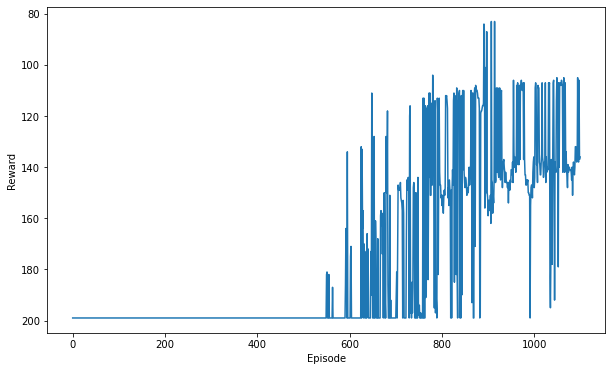

In [12]:
""" Batch : 16, Gamma : 0.95 """
plt.figure(figsize=(10, 6))
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.gca().invert_yaxis()
plt.show()

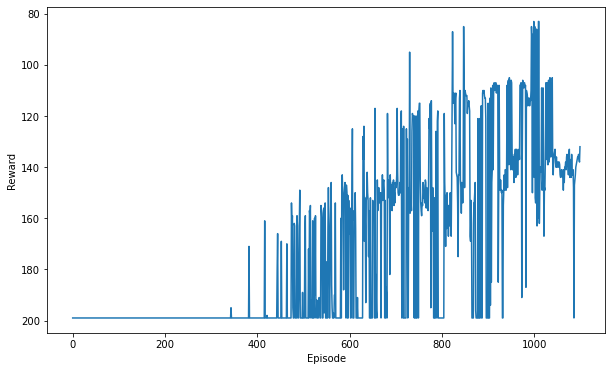

In [26]:
""" Batch : 32, Gamma : 0.95 """
plt.figure(figsize=(10, 6))
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.gca().invert_yaxis()
plt.show()

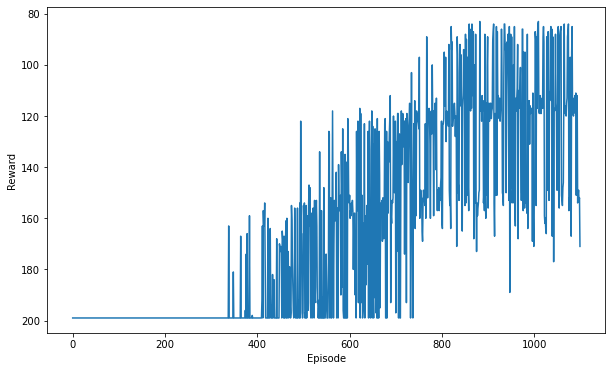

In [7]:
""" Batch : 64, Gamma : 0.85 """
plt.figure(figsize=(10, 6))
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.gca().invert_yaxis()
plt.show()